The goal of the home price regression competition is to predict the sale price of the home based on information about the home. The competition is described at https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

The data is described in data_predictions.txt.

Import the necessary packages

In [18]:
# Core
import numpy as np
import pandas as pd
import os
import random

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression

# Tree-based model
import xgboost as xgb

Set the random seed to 42 to ensure repeatability.

In [19]:
RANDOM_STATE = 42
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
seed_everything(seed=RANDOM_STATE)

Set the location of the data files based on running on local machine or kaggle website.

In [20]:
KAGGLE = False

In [21]:
if KAGGLE:
    train_csv = ''
    test_csv = ''
else:
    train_csv = '/Users/roberthennessy/Documents/machine learning/house price/data/train.csv'
    test_csv = '/Users/roberthennessy/Documents/machine learning/house price/data/test.csv'
    

train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

In [22]:
print(train_df.shape)
print(test_df.shape)

(1460, 81)
(1459, 80)


Separate the data into X and y.

In [23]:
X = train_df.drop(columns=['SalePrice', 'Id'])
y = np.log1p(train_df['SalePrice'])

Create list of columns that are numeric or categorical.

In [26]:
cat_cols = X.select_dtypes(include=["object"]).columns
num_cols = X.select_dtypes(exclude=["object"]).columns

len(cat_cols), len(num_cols)

(43, 36)

Check for duplicated rows in the train and test dataset.

In [24]:
print("Duplicated Rows in Train:",train_df.duplicated().sum())
print("Duplicated Rows in Test:",test_df.duplicated().sum())

Duplicated Rows in Train: 0
Duplicated Rows in Test: 0


There are no duplicated rows in the train and test set.

Check for missing values in the data.

In [25]:
missing_vals_train = train_df.isnull().sum().sort_values(ascending=False) / len(train_df)
missing_vals_train.name = 'Train'
missing_vals_test = test_df.isnull().sum().sort_values(ascending=False) / len(test_df)
missing_vals_test.name = 'Test'
print(pd.concat([missing_vals_train, missing_vals_test], axis=1).to_string())

                  Train      Test
PoolQC         0.995205  0.997944
MiscFeature    0.963014  0.965045
Alley          0.937671  0.926662
Fence          0.807534  0.801234
MasVnrType     0.597260  0.612748
FireplaceQu    0.472603  0.500343
LotFrontage    0.177397  0.155586
GarageYrBlt    0.055479  0.053461
GarageCond     0.055479  0.053461
GarageType     0.055479  0.052090
GarageFinish   0.055479  0.053461
GarageQual     0.055479  0.053461
BsmtFinType2   0.026027  0.028787
BsmtExposure   0.026027  0.030158
BsmtQual       0.025342  0.030158
BsmtCond       0.025342  0.030843
BsmtFinType1   0.025342  0.028787
MasVnrArea     0.005479  0.010281
Electrical     0.000685  0.000000
Id             0.000000  0.000000
Functional     0.000000  0.001371
Fireplaces     0.000000  0.000000
KitchenQual    0.000000  0.000685
KitchenAbvGr   0.000000  0.000000
BedroomAbvGr   0.000000  0.000000
HalfBath       0.000000  0.000000
FullBath       0.000000  0.000000
BsmtHalfBath   0.000000  0.001371
TotRmsAbvGrd  

There are some columns that have a lot of NaNs. However, for some columns, NaNs are expected. For example, pool quality is Na if no pool exists. For those rows, Nas should not be imputed.

In [64]:
rows_na_expected = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

In [68]:
missing_vals_train = train_df.drop(columns=rows_na_expected).isnull().sum().sort_values(ascending=False) / len(train_df)
missing_vals_train.name = 'Train'
missing_vals_test = test_df.drop(columns=rows_na_expected).isnull().sum().sort_values(ascending=False) / len(test_df)
missing_vals_test.name = 'Test'

print('train')
print(missing_vals_train.to_string())
print('test')
print(print(missing_vals_test.to_string()))

train
MasVnrType       0.597260
LotFrontage      0.177397
GarageYrBlt      0.055479
MasVnrArea       0.005479
Electrical       0.000685
YrSold           0.000000
MoSold           0.000000
1stFlrSF         0.000000
2ndFlrSF         0.000000
LowQualFinSF     0.000000
GrLivArea        0.000000
BsmtFullBath     0.000000
BsmtHalfBath     0.000000
FullBath         0.000000
HalfBath         0.000000
SaleCondition    0.000000
SaleType         0.000000
BedroomAbvGr     0.000000
KitchenAbvGr     0.000000
KitchenQual      0.000000
TotRmsAbvGrd     0.000000
Functional       0.000000
Fireplaces       0.000000
CentralAir       0.000000
GarageCars       0.000000
GarageArea       0.000000
PavedDrive       0.000000
WoodDeckSF       0.000000
OpenPorchSF      0.000000
EnclosedPorch    0.000000
3SsnPorch        0.000000
ScreenPorch      0.000000
PoolArea         0.000000
MiscVal          0.000000
Id               0.000000
Heating          0.000000
HeatingQC        0.000000
OverallQual      0.000000
MSZoni

There are four columns that have missing values: MasVnrType, LotFrontage, GarageYrBl, MasVnrArea and Electricl. Looking at data description, MasVnrType is categorical and uses None to indicate no masonry veneer. Therefore, this column will not be imputed. LotFrontage,  GarageYrBlt and MasVnrArea are numerical columns and will need to be imputed.

In [69]:
print(train_df['MasVnrType'].value_counts(dropna=False))

MasVnrType
NaN        872
BrkFace    445
Stone      128
BrkCmn      15
Name: count, dtype: int64


In most cases, the garage and house should be built at the same time. Let's check if that is true in the data.

<Axes: >

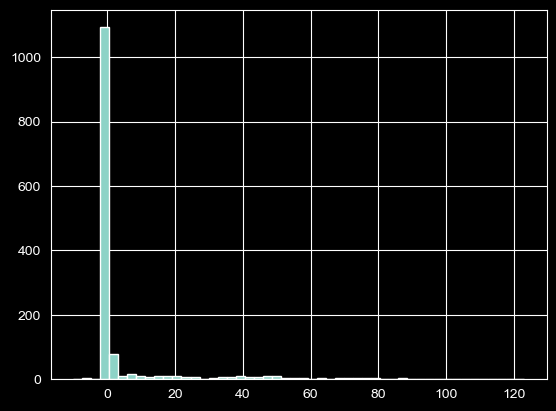

In [70]:
dif_gar_house_built = train_df['GarageYrBlt'] - train_df['YearBuilt']
dif_gar_house_built.hist(bins=50)

In [27]:
def describe_col(col): 
    train_describe = train_df[col].describe()
    train_describe['per missing'] = train_df[col].isnull().sum()/len(train_df)
    train_describe.name = 'train_df'
    test_describe = test_df[col].describe()
    test_describe['per missing'] = test_df[col].isnull().sum()/len(test_df)
    test_describe.name = 'test_df'
    return pd.concat([train_describe, test_describe], axis=1)
print(num_cols[0])
print(describe_col(num_cols[0]))

MSSubClass
                train_df      test_df
count        1460.000000  1459.000000
mean           56.897260    57.378341
std            42.300571    42.746880
min            20.000000    20.000000
25%            20.000000    20.000000
50%            50.000000    50.000000
75%            70.000000    70.000000
max           190.000000   190.000000
per missing     0.000000     0.000000


In [28]:
def plot_overlaid_histograms(df1, df2, col, df1_label, df2_label, bins):
    # Plot overlaid histograms
    plt.hist(df1[col], bins=bins, alpha=0.7, label=df1_label, color='blue')
    plt.hist(df2[col], bins=bins, alpha=0.7, label=df2_label, color='orange')
    
    plt.title('Overlaid Histograms')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

def plot_multi_hist(df1, df2, col, df1_label, df2_label, bins):
    fig, axs = plt.subplots(1, 2, figsize=(15,6)) # 1 row, 2 columns
    axs[0].hist(df1[col], bins=bins, color='blue')
    axs[0].set_title(df1_label)
    axs[1].hist(df2[col], bins=bins, label=df2_label, color='orange')
    axs[1].set_title(df2_label)
    plt.show()

def plot_multi_hist2(df1, df2, col, df1_label, df2_label, bins):
    fig, axs = plt.subplots(1, 2, figsize=(15,6)) # 1 row, 2 columns
    df1[col].value_counts().sort_index(ascending=False).plot.hist(bins=bins, color='blue', ax=axs[0], title=df1_label)
    df2[col].value_counts().sort_index(ascending=False).plot.hist(bins=bins, color='orange', ax=axs[1], title=df2_label)
    plt.show()

def plot_multi_bar(df1, df2, col, df1_label, df2_label):
    fig, axs = plt.subplots(1, 2, figsize=(15,6)) # 1 row, 2 columns
    df1[col].value_counts().plot.bar(color='blue', ax=axs[0], title=df1_label)
    df2[col].value_counts().plot.bar(color='orange', ax=axs[1], title=df2_label)
    plt.show()

MSSubClass
                train_df      test_df
count        1460.000000  1459.000000
mean           56.897260    57.378341
std            42.300571    42.746880
min            20.000000    20.000000
25%            20.000000    20.000000
50%            50.000000    50.000000
75%            70.000000    70.000000
max           190.000000   190.000000
per missing     0.000000     0.000000


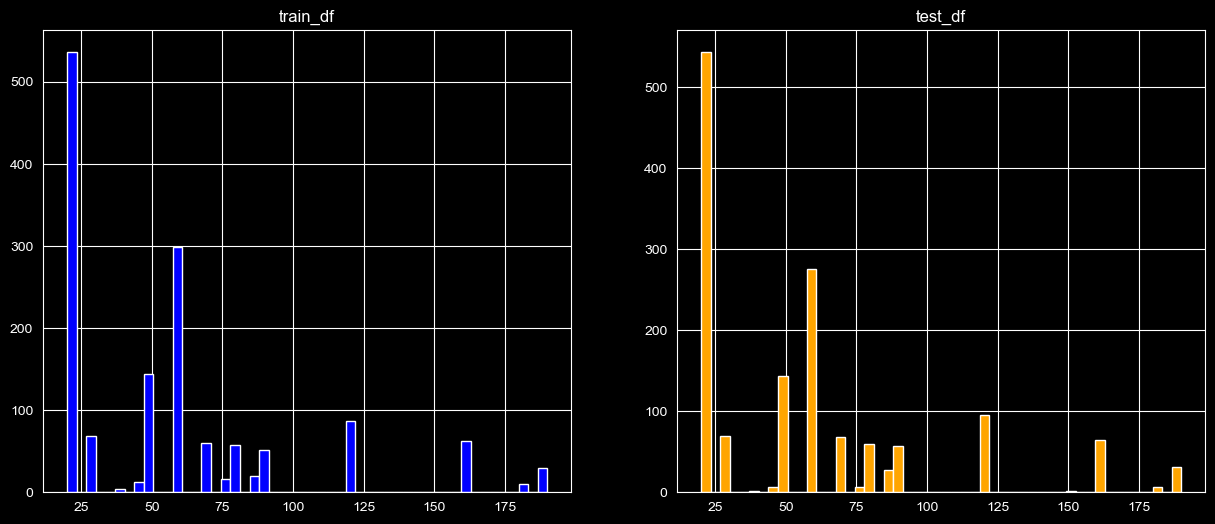

LotFrontage
                train_df      test_df
count        1201.000000  1232.000000
mean           70.049958    68.580357
std            24.284752    22.376841
min            21.000000    21.000000
25%            59.000000    58.000000
50%            69.000000    67.000000
75%            80.000000    80.000000
max           313.000000   200.000000
per missing     0.177397     0.155586


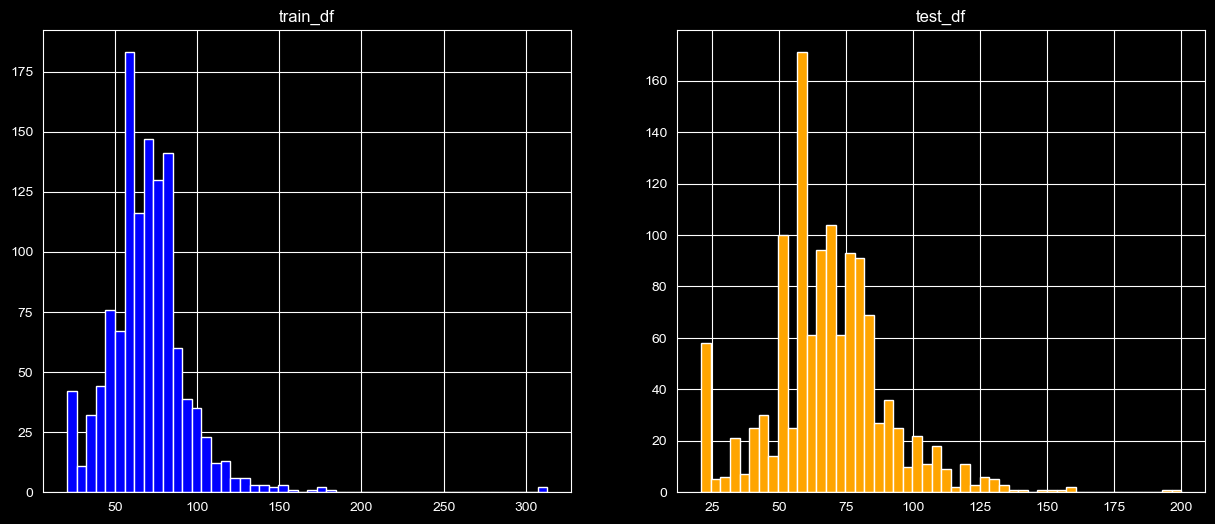

LotArea
                  train_df       test_df
count          1460.000000   1459.000000
mean          10516.828082   9819.161069
std            9981.264932   4955.517327
min            1300.000000   1470.000000
25%            7553.500000   7391.000000
50%            9478.500000   9399.000000
75%           11601.500000  11517.500000
max          215245.000000  56600.000000
per missing       0.000000      0.000000


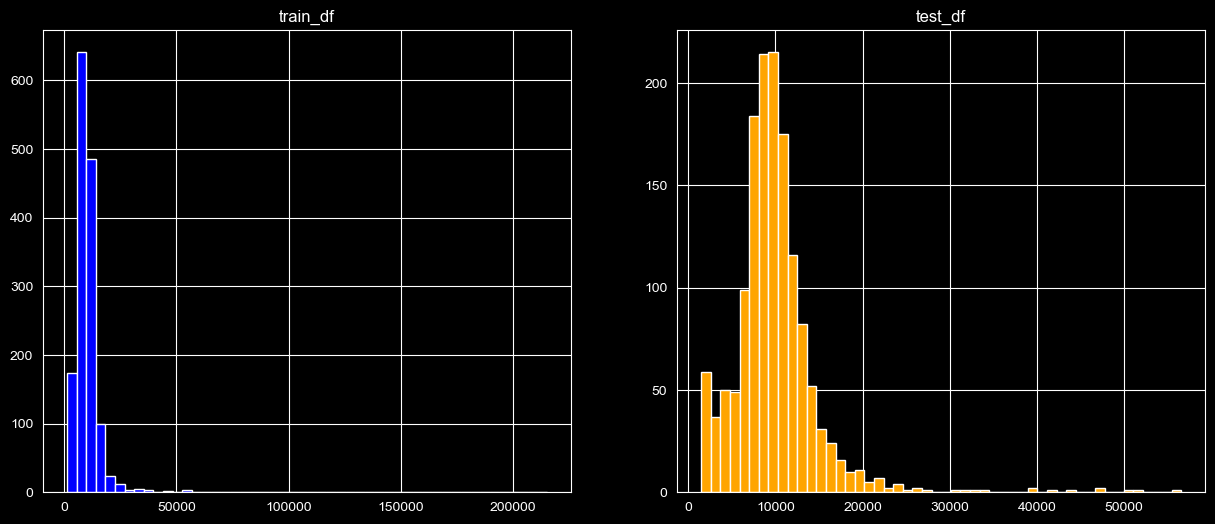

OverallQual
                train_df      test_df
count        1460.000000  1459.000000
mean            6.099315     6.078821
std             1.382997     1.436812
min             1.000000     1.000000
25%             5.000000     5.000000
50%             6.000000     6.000000
75%             7.000000     7.000000
max            10.000000    10.000000
per missing     0.000000     0.000000


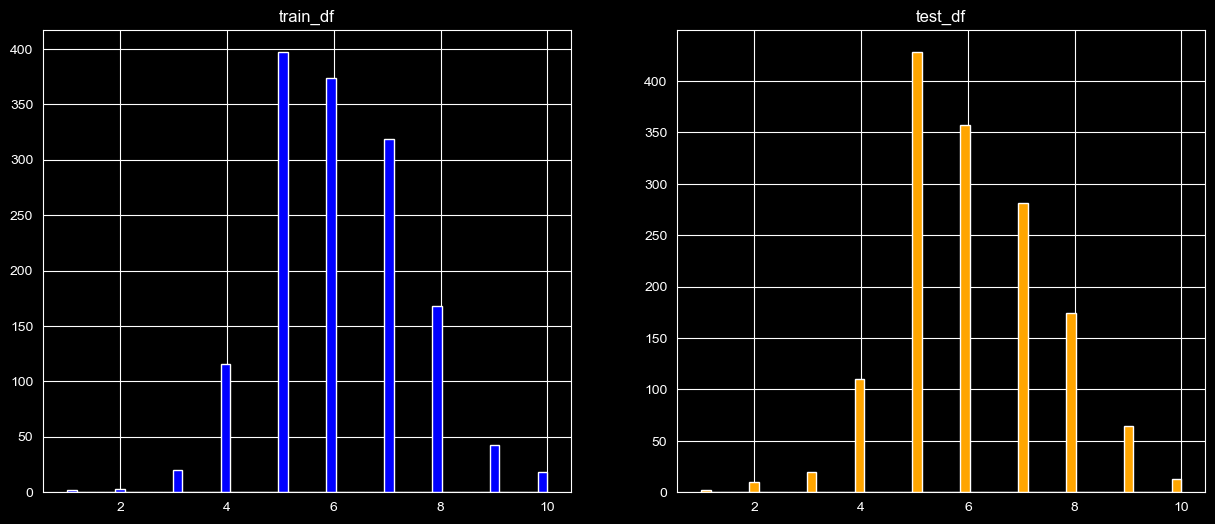

OverallCond
                train_df      test_df
count        1460.000000  1459.000000
mean            5.575342     5.553804
std             1.112799     1.113740
min             1.000000     1.000000
25%             5.000000     5.000000
50%             5.000000     5.000000
75%             6.000000     6.000000
max             9.000000     9.000000
per missing     0.000000     0.000000


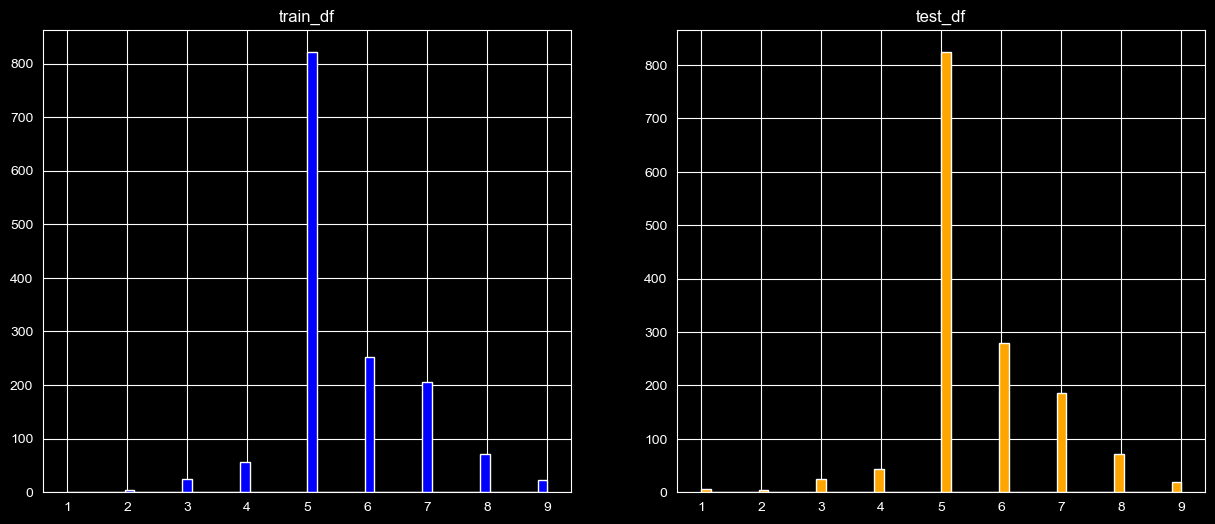

YearBuilt
                train_df      test_df
count        1460.000000  1459.000000
mean         1971.267808  1971.357779
std            30.202904    30.390071
min          1872.000000  1879.000000
25%          1954.000000  1953.000000
50%          1973.000000  1973.000000
75%          2000.000000  2001.000000
max          2010.000000  2010.000000
per missing     0.000000     0.000000


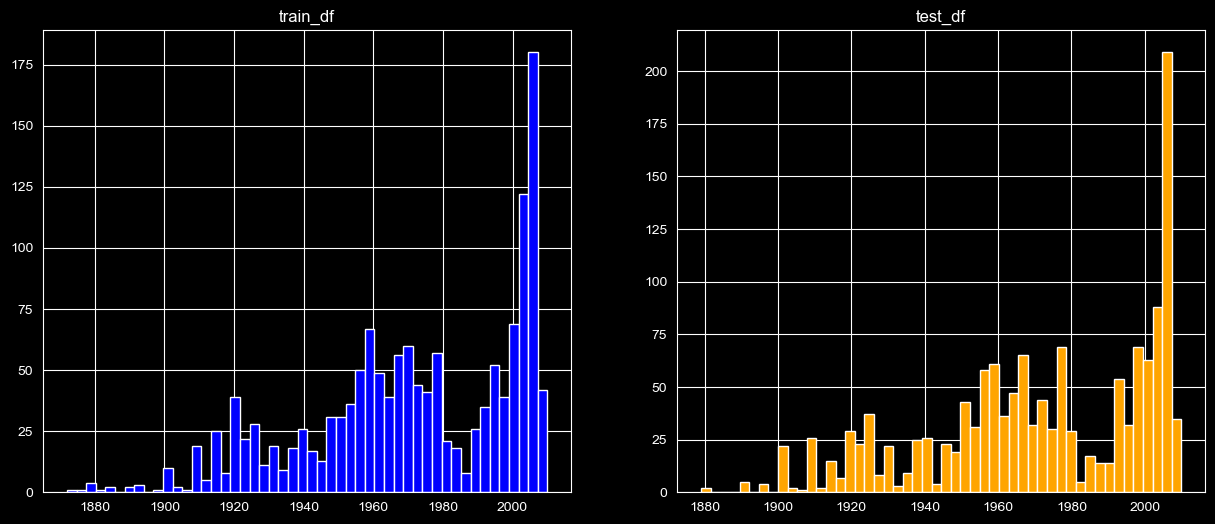

YearRemodAdd
                train_df      test_df
count        1460.000000  1459.000000
mean         1984.865753  1983.662783
std            20.645407    21.130467
min          1950.000000  1950.000000
25%          1967.000000  1963.000000
50%          1994.000000  1992.000000
75%          2004.000000  2004.000000
max          2010.000000  2010.000000
per missing     0.000000     0.000000


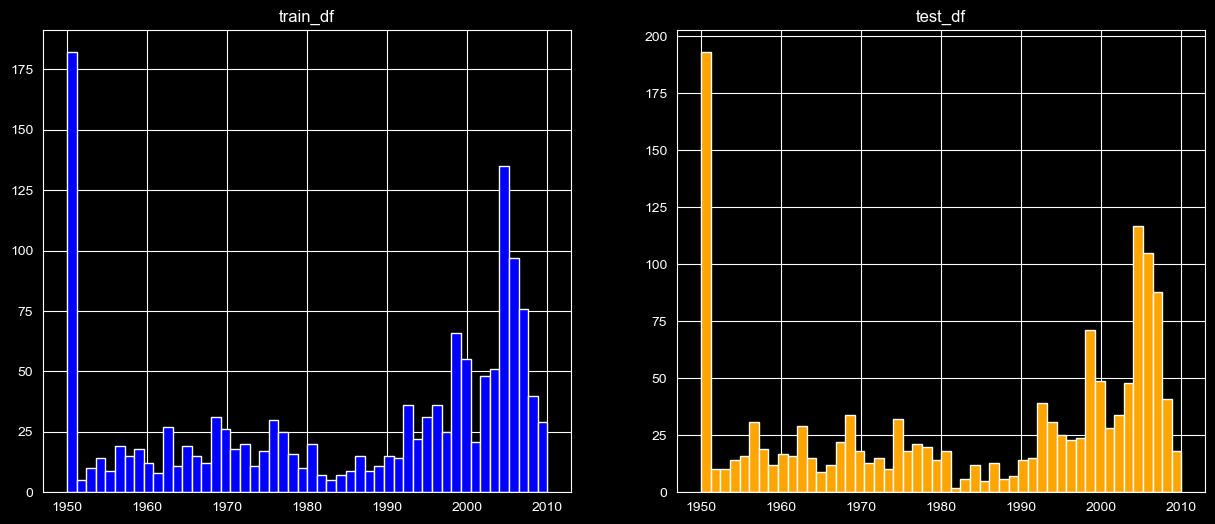

MasVnrArea
                train_df      test_df
count        1452.000000  1444.000000
mean          103.685262   100.709141
std           181.066207   177.625900
min             0.000000     0.000000
25%             0.000000     0.000000
50%             0.000000     0.000000
75%           166.000000   164.000000
max          1600.000000  1290.000000
per missing     0.005479     0.010281


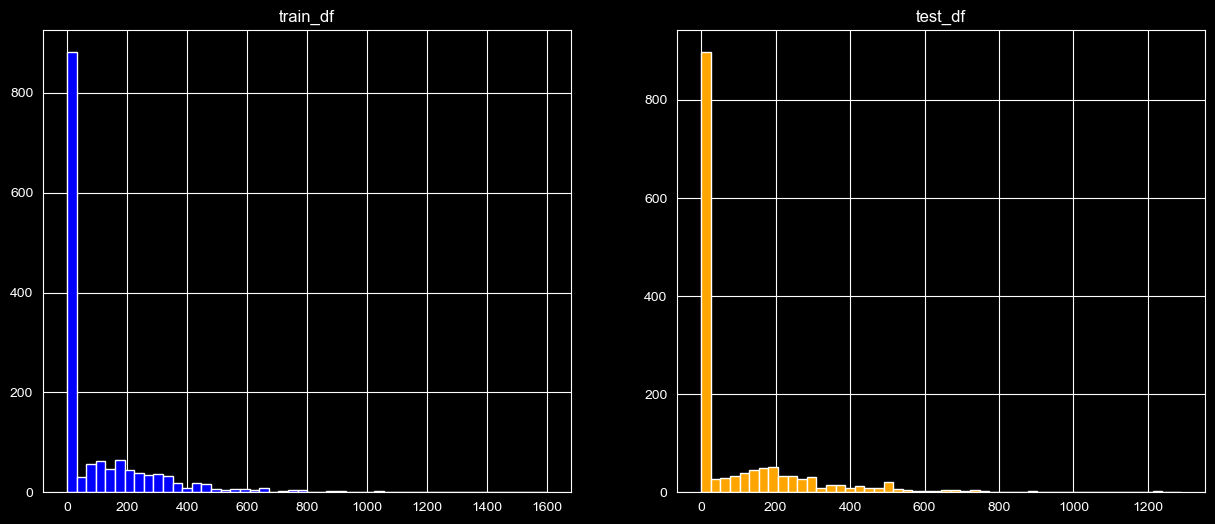

BsmtFinSF1
                train_df      test_df
count        1460.000000  1458.000000
mean          443.639726   439.203704
std           456.098091   455.268042
min             0.000000     0.000000
25%             0.000000     0.000000
50%           383.500000   350.500000
75%           712.250000   753.500000
max          5644.000000  4010.000000
per missing     0.000000     0.000685


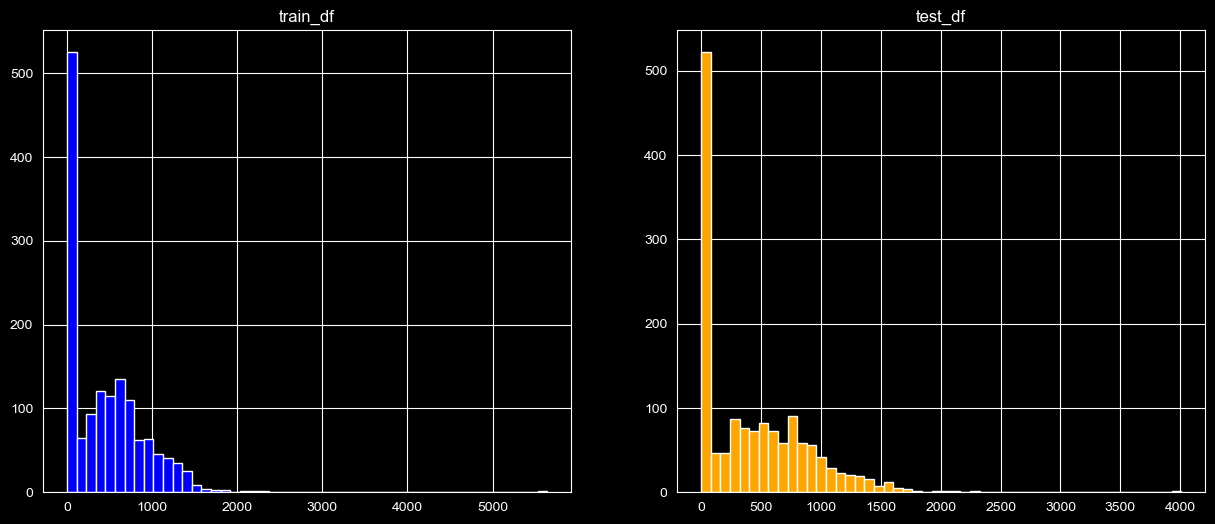

BsmtFinSF2
                train_df      test_df
count        1460.000000  1458.000000
mean           46.549315    52.619342
std           161.319273   176.753926
min             0.000000     0.000000
25%             0.000000     0.000000
50%             0.000000     0.000000
75%             0.000000     0.000000
max          1474.000000  1526.000000
per missing     0.000000     0.000685


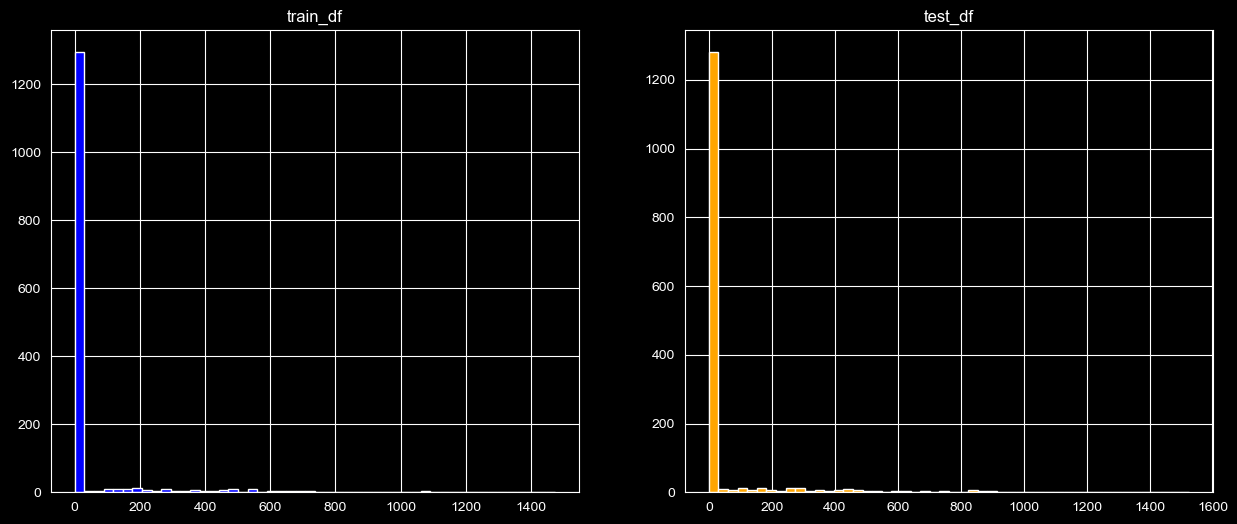

BsmtUnfSF
                train_df      test_df
count        1460.000000  1458.000000
mean          567.240411   554.294925
std           441.866955   437.260486
min             0.000000     0.000000
25%           223.000000   219.250000
50%           477.500000   460.000000
75%           808.000000   797.750000
max          2336.000000  2140.000000
per missing     0.000000     0.000685


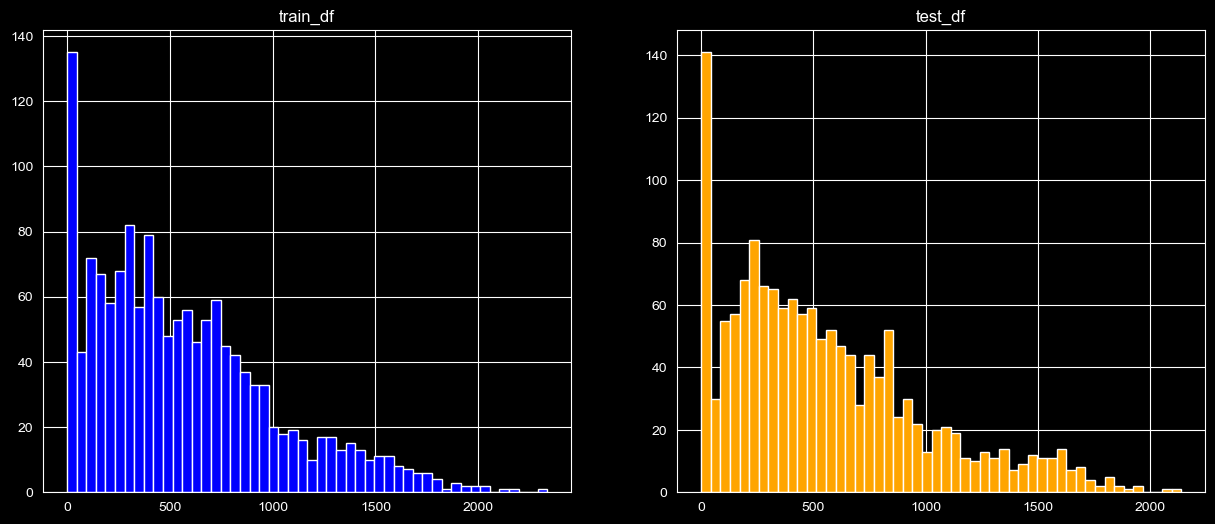

TotalBsmtSF
                train_df      test_df
count        1460.000000  1458.000000
mean         1057.429452  1046.117970
std           438.705324   442.898624
min             0.000000     0.000000
25%           795.750000   784.000000
50%           991.500000   988.000000
75%          1298.250000  1305.000000
max          6110.000000  5095.000000
per missing     0.000000     0.000685


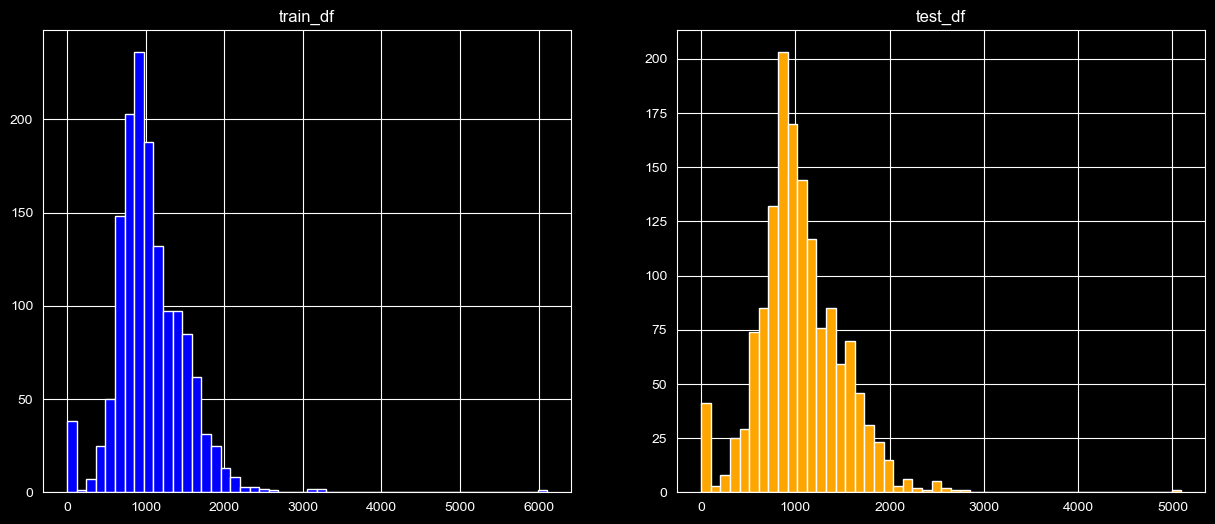

1stFlrSF
                train_df      test_df
count        1460.000000  1459.000000
mean         1162.626712  1156.534613
std           386.587738   398.165820
min           334.000000   407.000000
25%           882.000000   873.500000
50%          1087.000000  1079.000000
75%          1391.250000  1382.500000
max          4692.000000  5095.000000
per missing     0.000000     0.000000


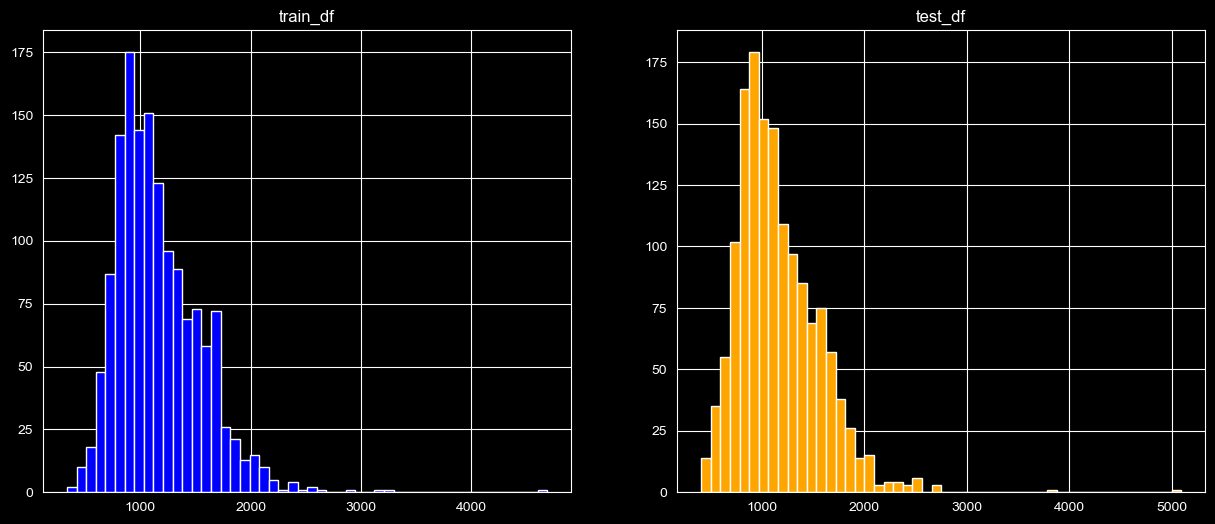

2ndFlrSF
                train_df      test_df
count        1460.000000  1459.000000
mean          346.992466   325.967786
std           436.528436   420.610226
min             0.000000     0.000000
25%             0.000000     0.000000
50%             0.000000     0.000000
75%           728.000000   676.000000
max          2065.000000  1862.000000
per missing     0.000000     0.000000


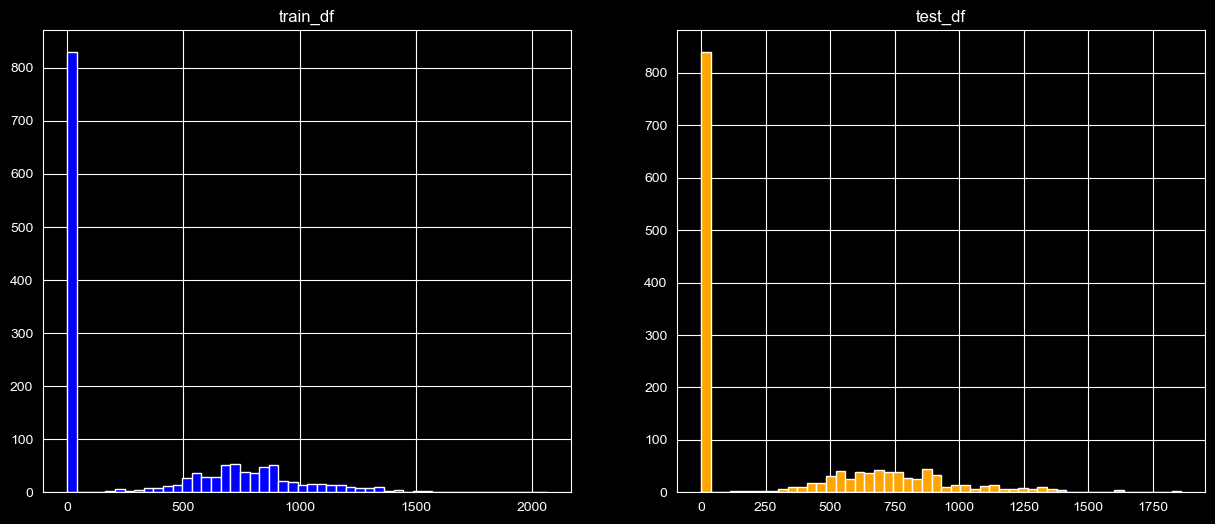

LowQualFinSF
                train_df      test_df
count        1460.000000  1459.000000
mean            5.844521     3.543523
std            48.623081    44.043251
min             0.000000     0.000000
25%             0.000000     0.000000
50%             0.000000     0.000000
75%             0.000000     0.000000
max           572.000000  1064.000000
per missing     0.000000     0.000000


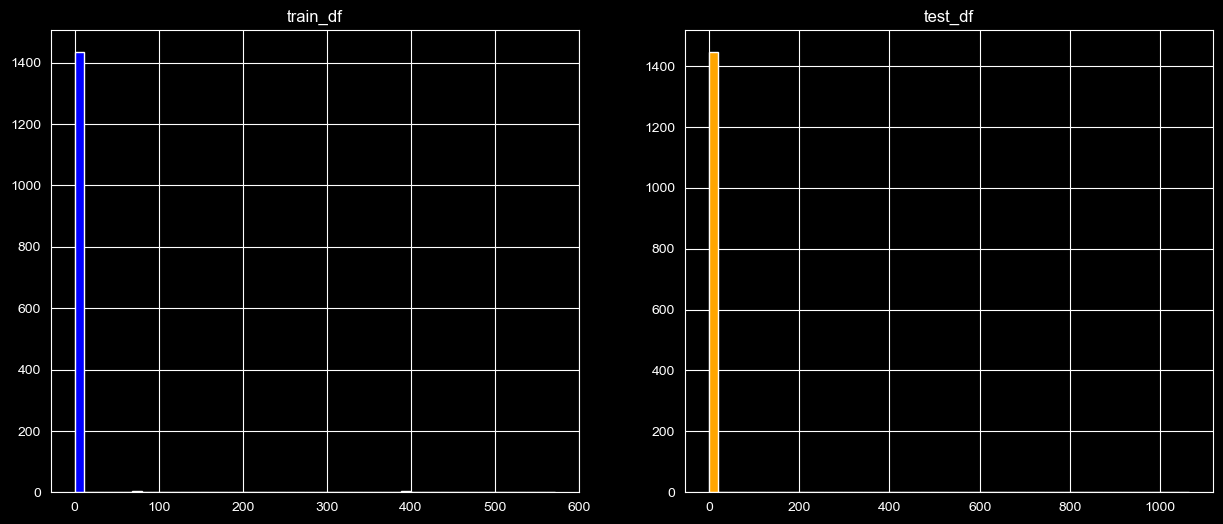

GrLivArea
                train_df      test_df
count        1460.000000  1459.000000
mean         1515.463699  1486.045922
std           525.480383   485.566099
min           334.000000   407.000000
25%          1129.500000  1117.500000
50%          1464.000000  1432.000000
75%          1776.750000  1721.000000
max          5642.000000  5095.000000
per missing     0.000000     0.000000


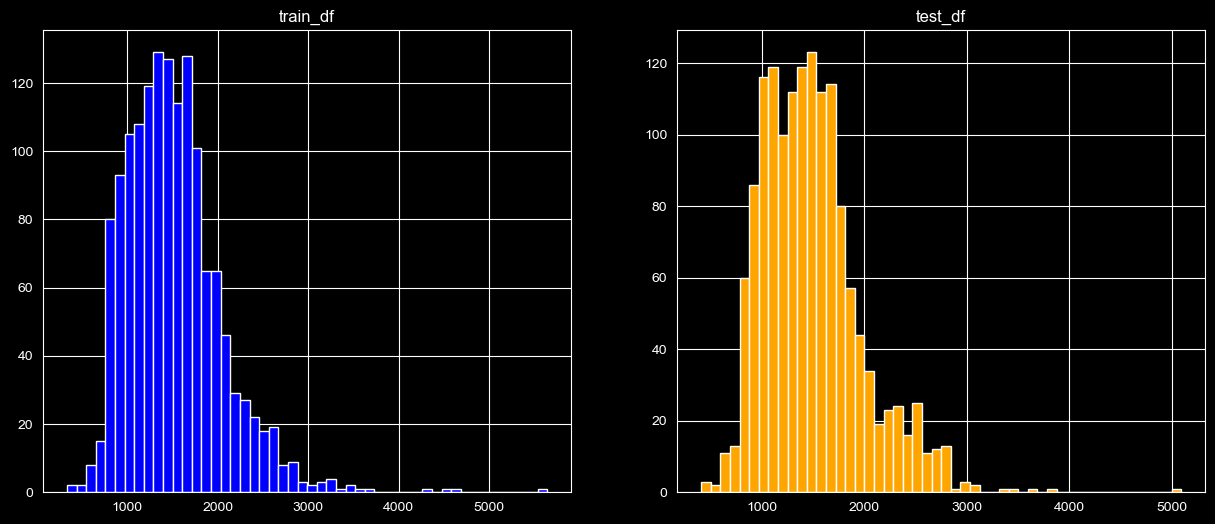

BsmtFullBath
                train_df      test_df
count        1460.000000  1457.000000
mean            0.425342     0.434454
std             0.518911     0.530648
min             0.000000     0.000000
25%             0.000000     0.000000
50%             0.000000     0.000000
75%             1.000000     1.000000
max             3.000000     3.000000
per missing     0.000000     0.001371


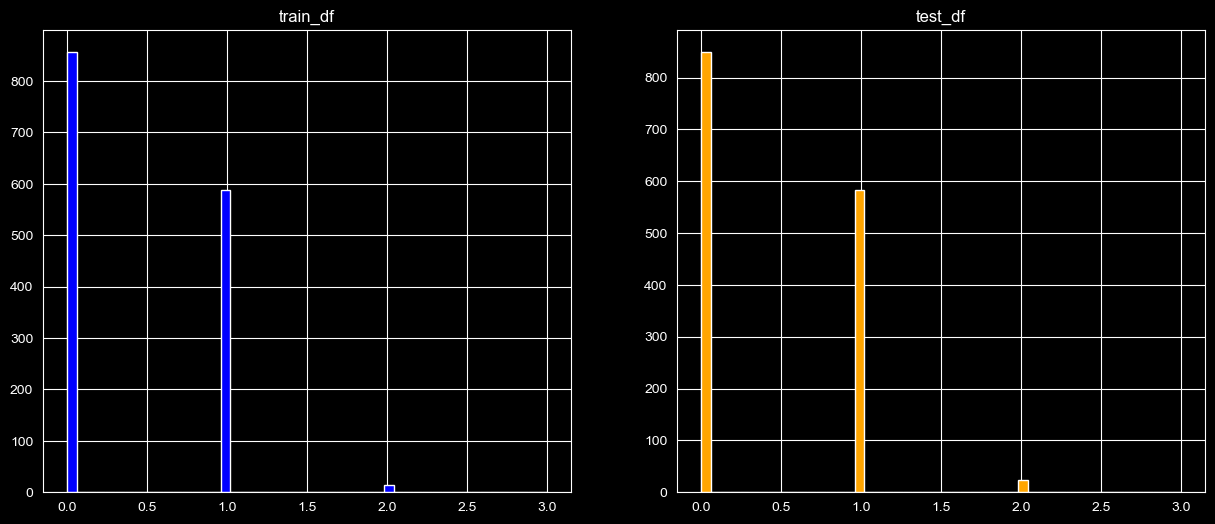

BsmtHalfBath
                train_df      test_df
count        1460.000000  1457.000000
mean            0.057534     0.065202
std             0.238753     0.252468
min             0.000000     0.000000
25%             0.000000     0.000000
50%             0.000000     0.000000
75%             0.000000     0.000000
max             2.000000     2.000000
per missing     0.000000     0.001371


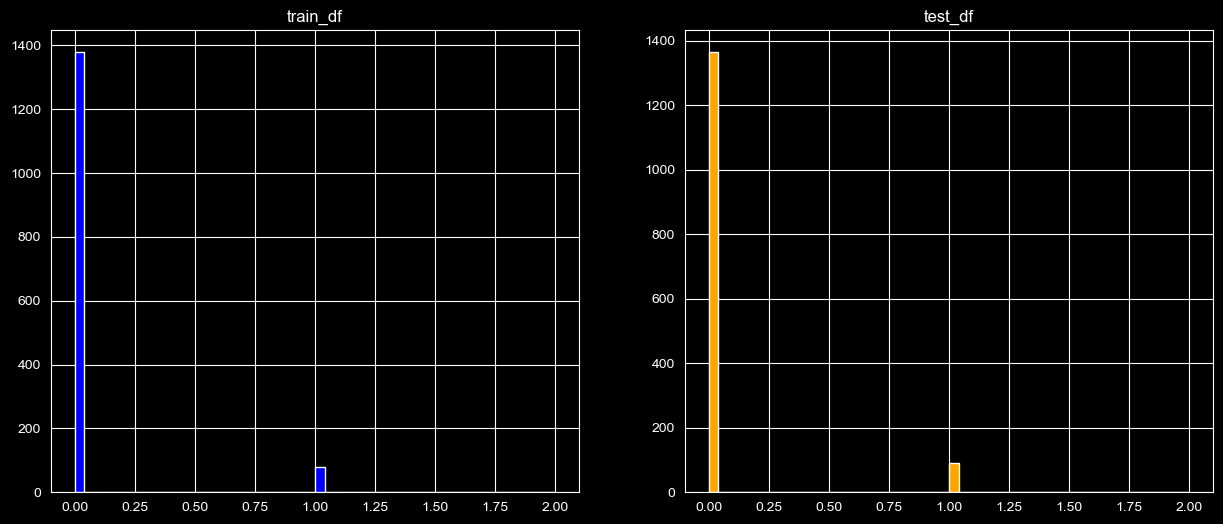

FullBath
                train_df      test_df
count        1460.000000  1459.000000
mean            1.565068     1.570939
std             0.550916     0.555190
min             0.000000     0.000000
25%             1.000000     1.000000
50%             2.000000     2.000000
75%             2.000000     2.000000
max             3.000000     4.000000
per missing     0.000000     0.000000


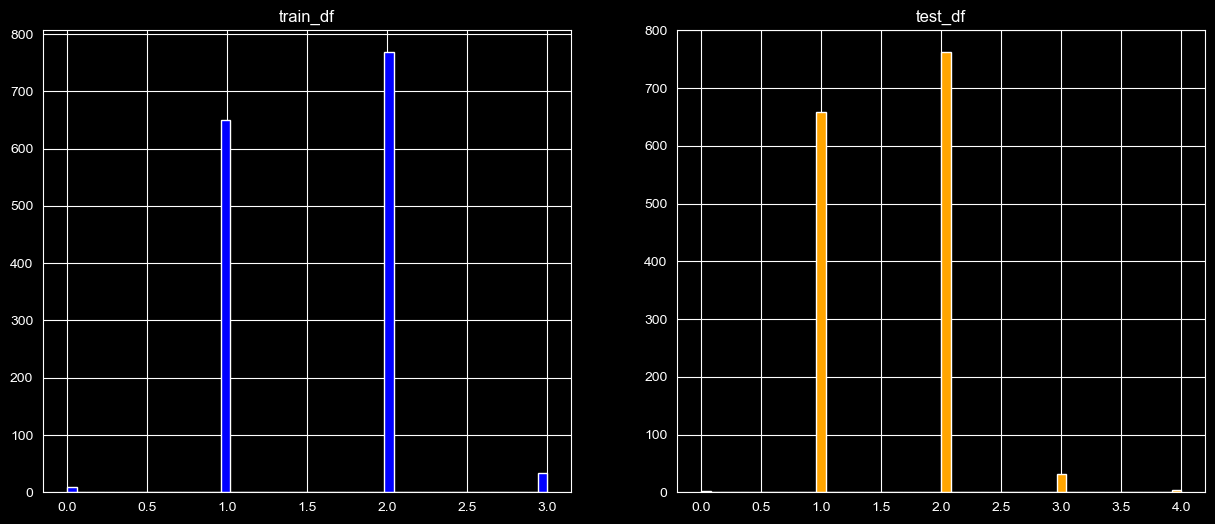

HalfBath
                train_df      test_df
count        1460.000000  1459.000000
mean            0.382877     0.377656
std             0.502885     0.503017
min             0.000000     0.000000
25%             0.000000     0.000000
50%             0.000000     0.000000
75%             1.000000     1.000000
max             2.000000     2.000000
per missing     0.000000     0.000000


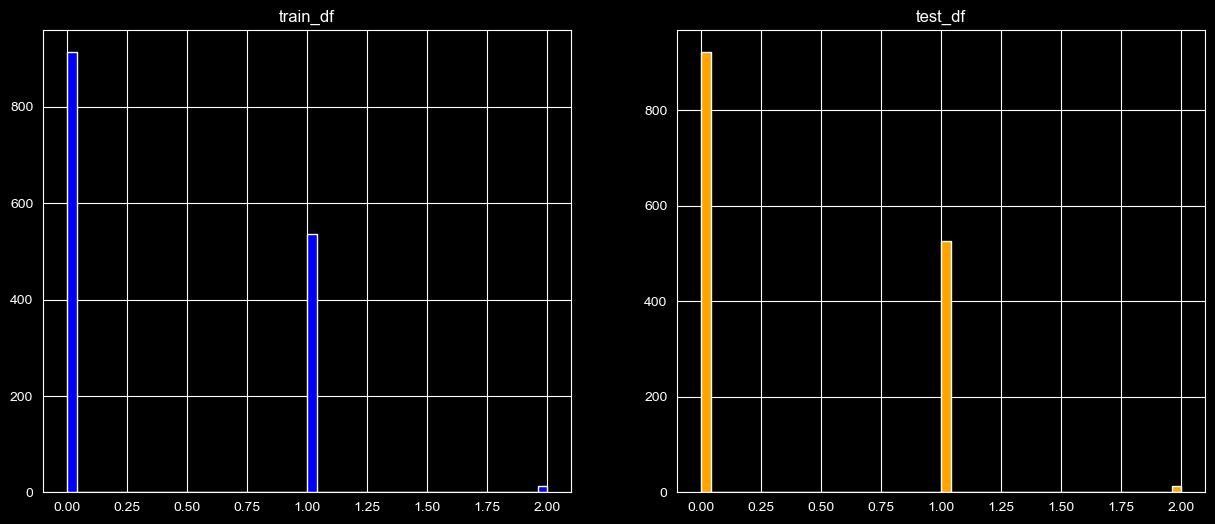

BedroomAbvGr
                train_df      test_df
count        1460.000000  1459.000000
mean            2.866438     2.854010
std             0.815778     0.829788
min             0.000000     0.000000
25%             2.000000     2.000000
50%             3.000000     3.000000
75%             3.000000     3.000000
max             8.000000     6.000000
per missing     0.000000     0.000000


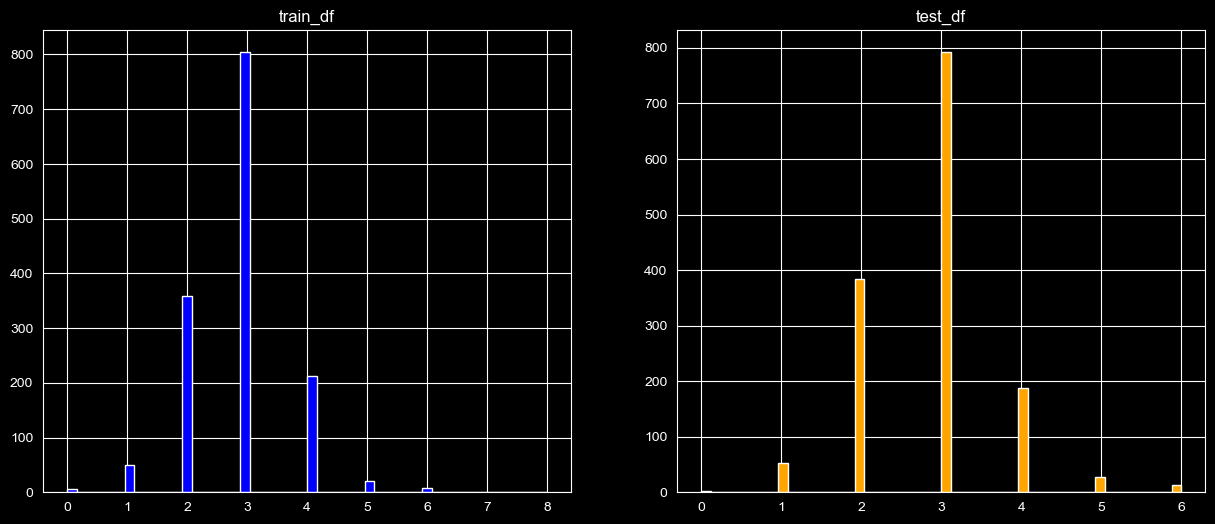

KitchenAbvGr
                train_df      test_df
count        1460.000000  1459.000000
mean            1.046575     1.042495
std             0.220338     0.208472
min             0.000000     0.000000
25%             1.000000     1.000000
50%             1.000000     1.000000
75%             1.000000     1.000000
max             3.000000     2.000000
per missing     0.000000     0.000000


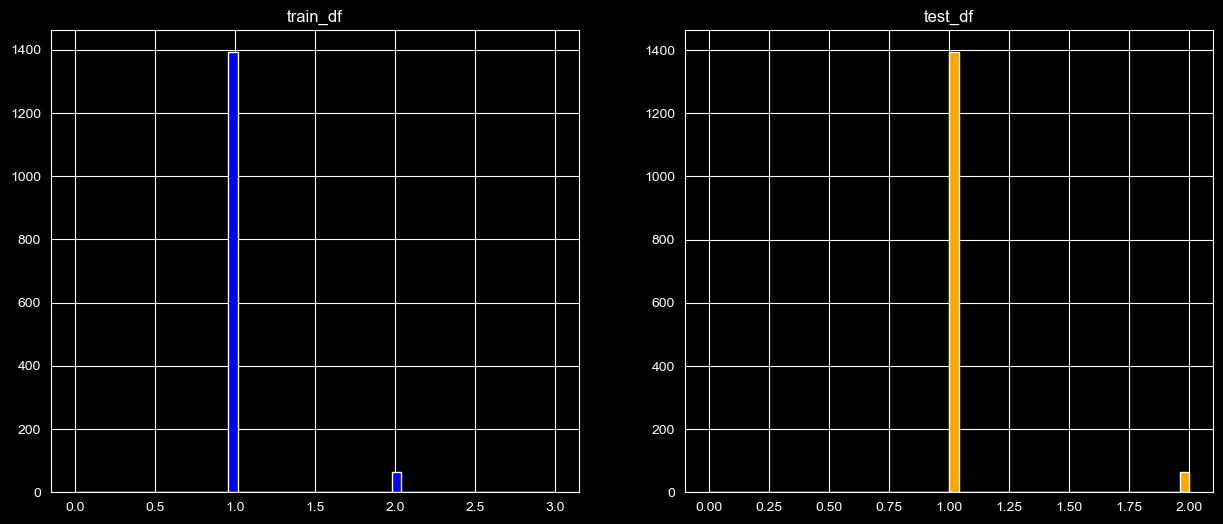

TotRmsAbvGrd
                train_df      test_df
count        1460.000000  1459.000000
mean            6.517808     6.385195
std             1.625393     1.508895
min             2.000000     3.000000
25%             5.000000     5.000000
50%             6.000000     6.000000
75%             7.000000     7.000000
max            14.000000    15.000000
per missing     0.000000     0.000000


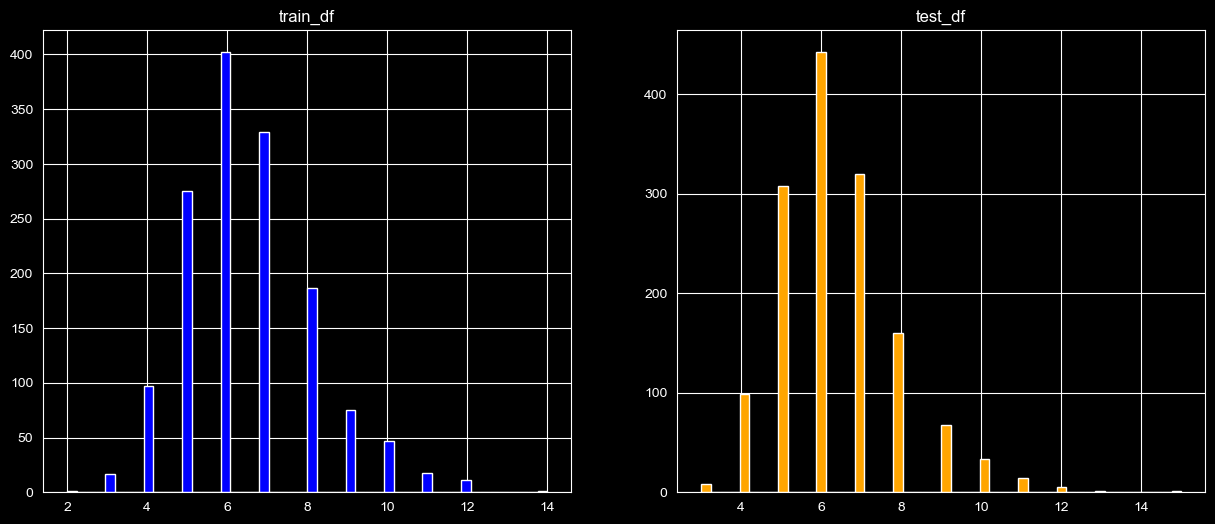

Fireplaces
                train_df     test_df
count        1460.000000  1459.00000
mean            0.613014     0.58122
std             0.644666     0.64742
min             0.000000     0.00000
25%             0.000000     0.00000
50%             1.000000     0.00000
75%             1.000000     1.00000
max             3.000000     4.00000
per missing     0.000000     0.00000


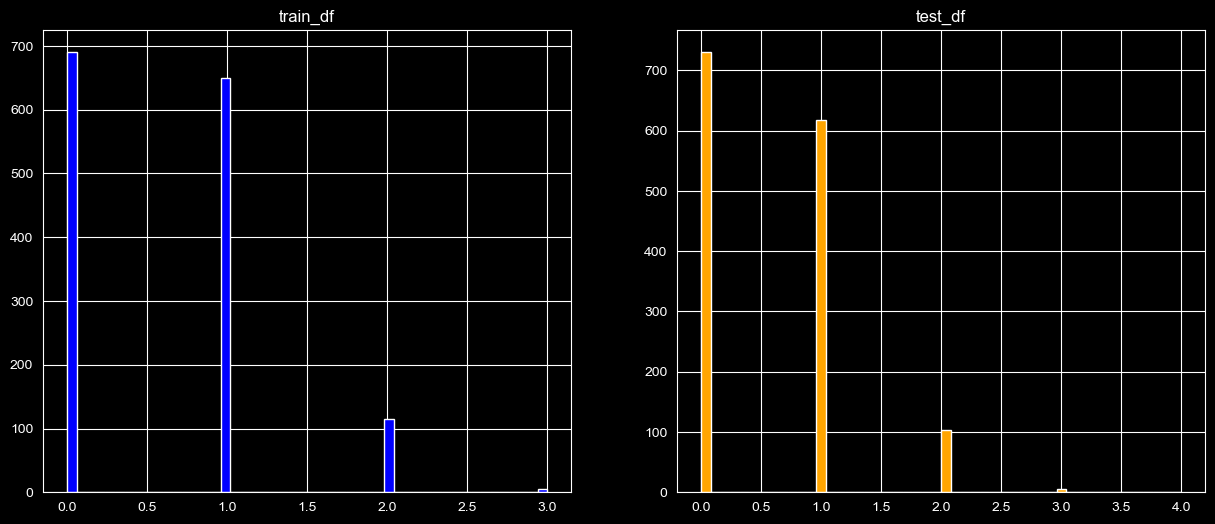

GarageYrBlt
                train_df      test_df
count        1379.000000  1381.000000
mean         1978.506164  1977.721217
std            24.689725    26.431175
min          1900.000000  1895.000000
25%          1961.000000  1959.000000
50%          1980.000000  1979.000000
75%          2002.000000  2002.000000
max          2010.000000  2207.000000
per missing     0.055479     0.053461


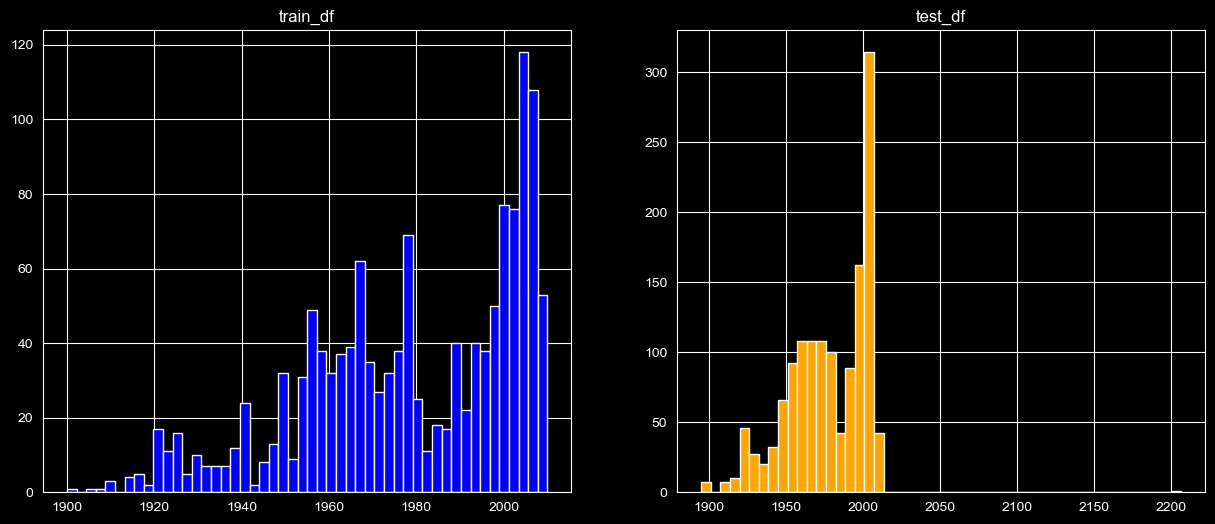

GarageCars
                train_df      test_df
count        1460.000000  1458.000000
mean            1.767123     1.766118
std             0.747315     0.775945
min             0.000000     0.000000
25%             1.000000     1.000000
50%             2.000000     2.000000
75%             2.000000     2.000000
max             4.000000     5.000000
per missing     0.000000     0.000685


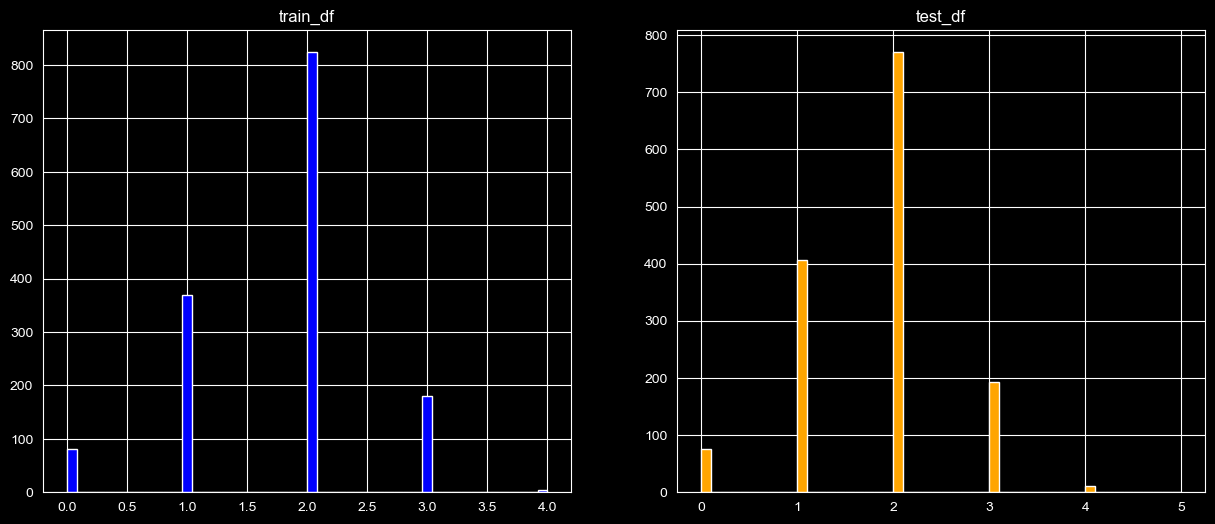

GarageArea
                train_df      test_df
count        1460.000000  1458.000000
mean          472.980137   472.768861
std           213.804841   217.048611
min             0.000000     0.000000
25%           334.500000   318.000000
50%           480.000000   480.000000
75%           576.000000   576.000000
max          1418.000000  1488.000000
per missing     0.000000     0.000685


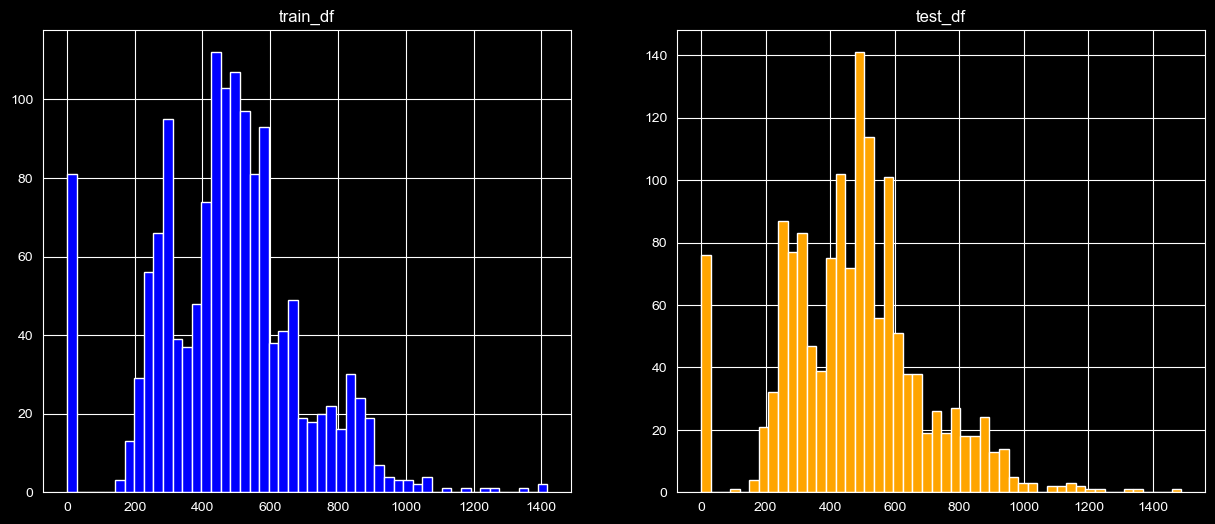

WoodDeckSF
                train_df      test_df
count        1460.000000  1459.000000
mean           94.244521    93.174777
std           125.338794   127.744882
min             0.000000     0.000000
25%             0.000000     0.000000
50%             0.000000     0.000000
75%           168.000000   168.000000
max           857.000000  1424.000000
per missing     0.000000     0.000000


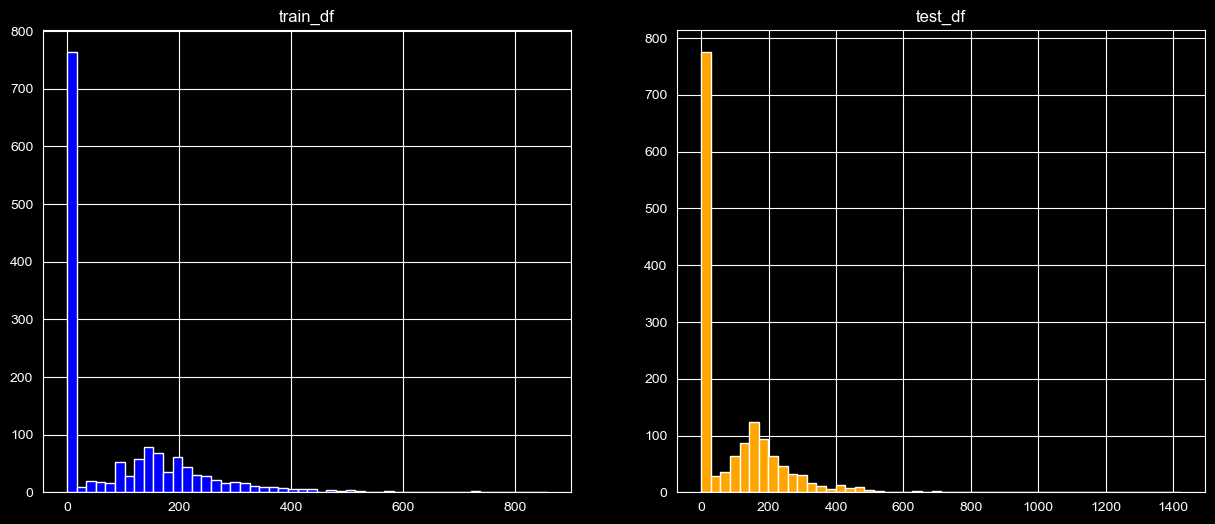

OpenPorchSF
                train_df      test_df
count        1460.000000  1459.000000
mean           46.660274    48.313914
std            66.256028    68.883364
min             0.000000     0.000000
25%             0.000000     0.000000
50%            25.000000    28.000000
75%            68.000000    72.000000
max           547.000000   742.000000
per missing     0.000000     0.000000


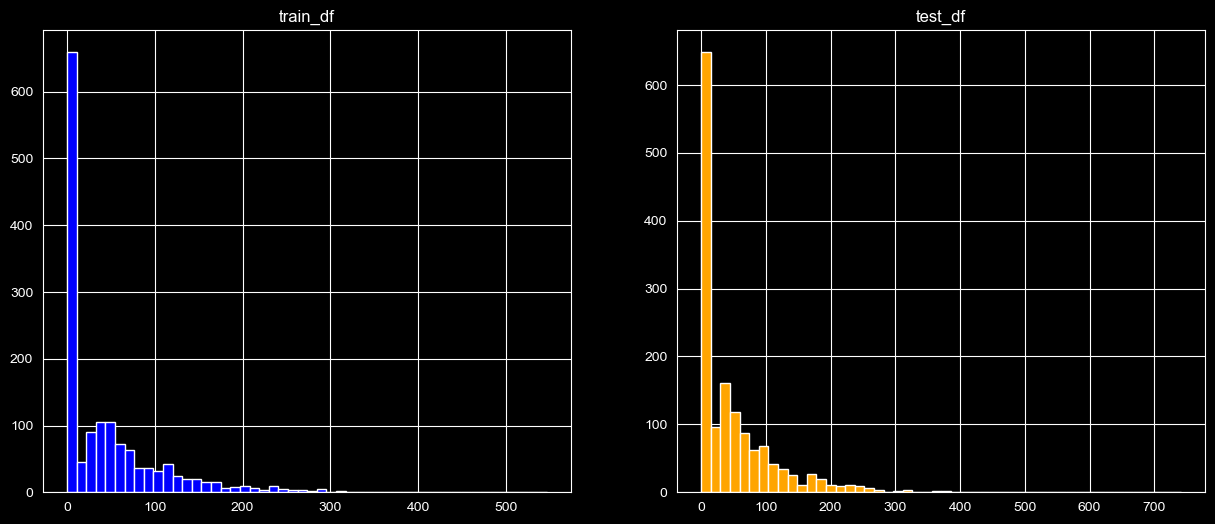

EnclosedPorch
                train_df      test_df
count        1460.000000  1459.000000
mean           21.954110    24.243317
std            61.119149    67.227765
min             0.000000     0.000000
25%             0.000000     0.000000
50%             0.000000     0.000000
75%             0.000000     0.000000
max           552.000000  1012.000000
per missing     0.000000     0.000000


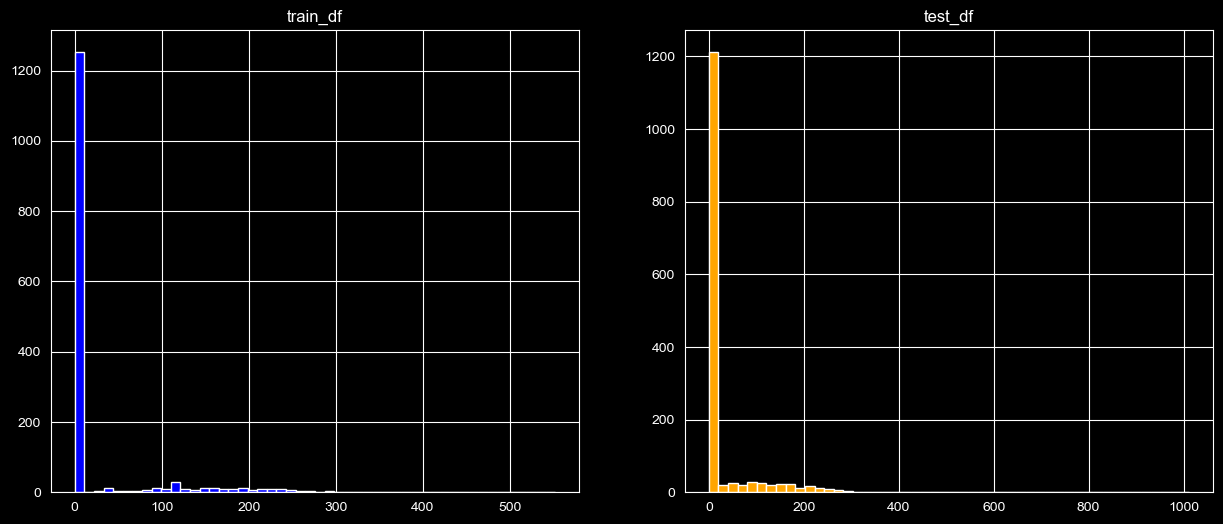

3SsnPorch
                train_df      test_df
count        1460.000000  1459.000000
mean            3.409589     1.794380
std            29.317331    20.207842
min             0.000000     0.000000
25%             0.000000     0.000000
50%             0.000000     0.000000
75%             0.000000     0.000000
max           508.000000   360.000000
per missing     0.000000     0.000000


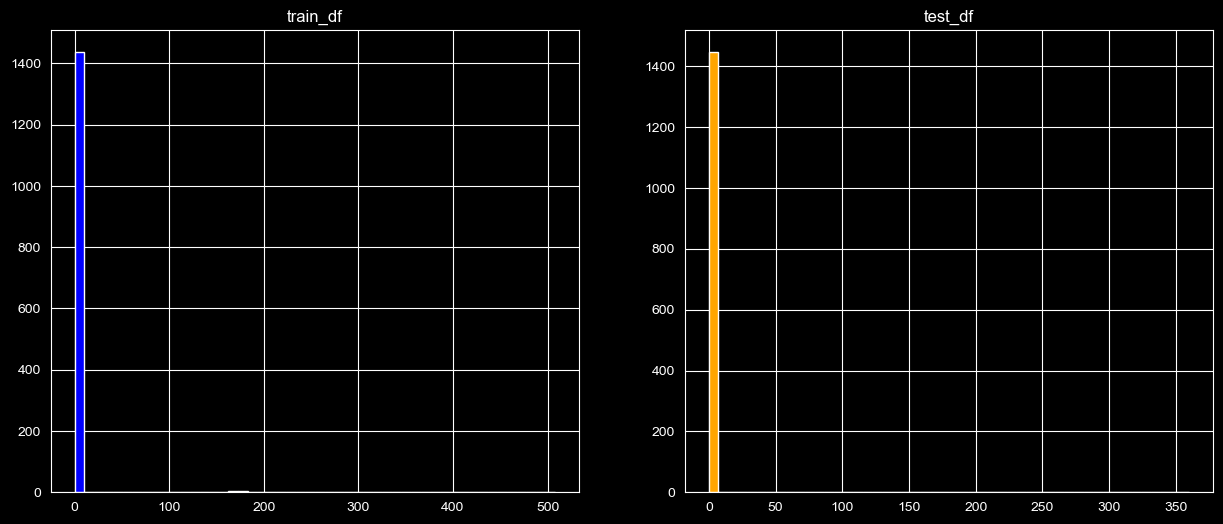

ScreenPorch
                train_df      test_df
count        1460.000000  1459.000000
mean           15.060959    17.064428
std            55.757415    56.609763
min             0.000000     0.000000
25%             0.000000     0.000000
50%             0.000000     0.000000
75%             0.000000     0.000000
max           480.000000   576.000000
per missing     0.000000     0.000000


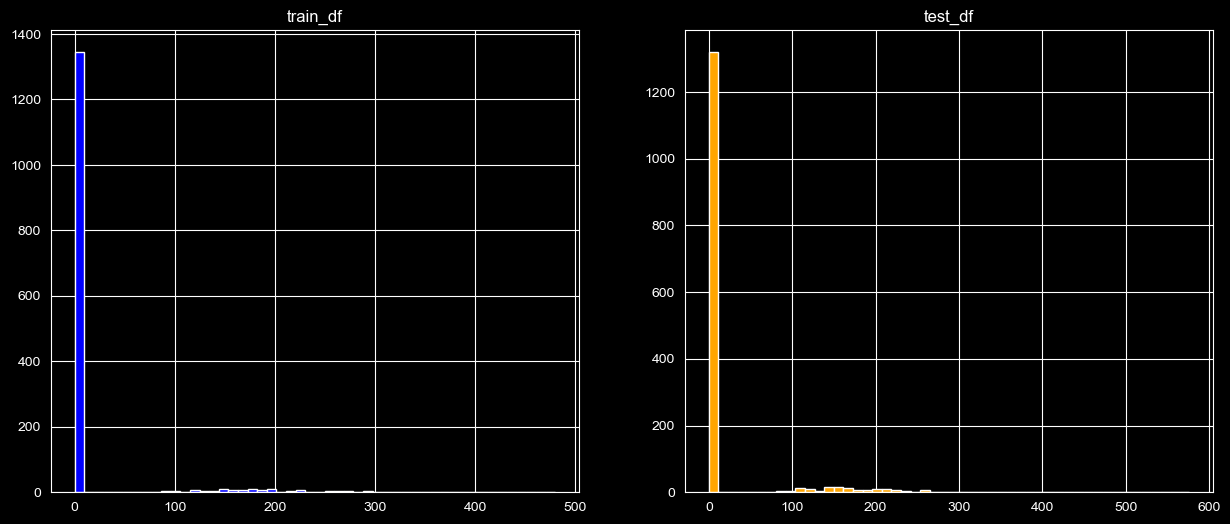

PoolArea
                train_df      test_df
count        1460.000000  1459.000000
mean            2.758904     1.744345
std            40.177307    30.491646
min             0.000000     0.000000
25%             0.000000     0.000000
50%             0.000000     0.000000
75%             0.000000     0.000000
max           738.000000   800.000000
per missing     0.000000     0.000000


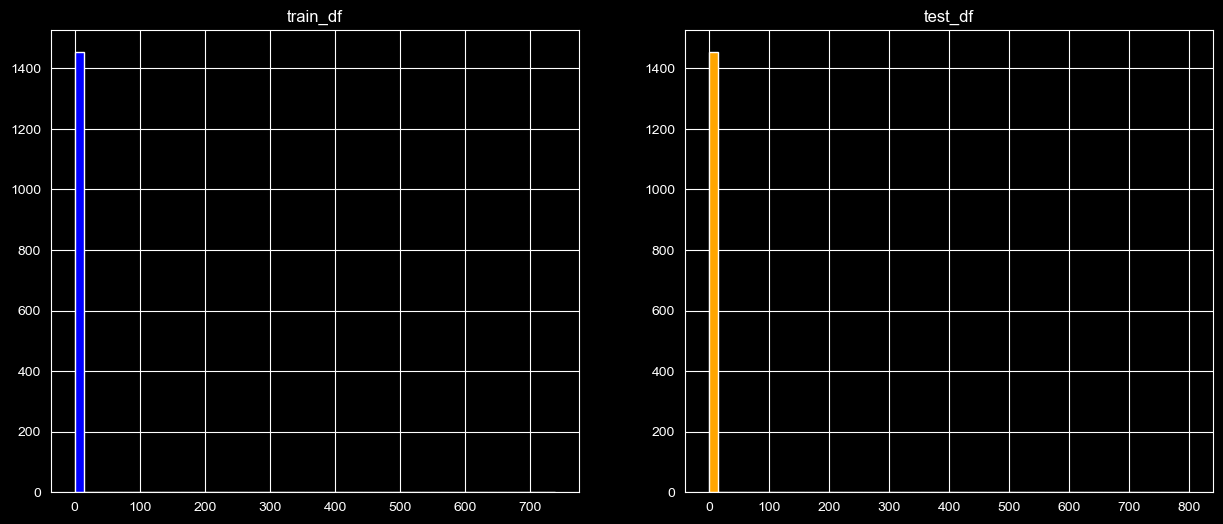

MiscVal
                 train_df       test_df
count         1460.000000   1459.000000
mean            43.489041     58.167923
std            496.123024    630.806978
min              0.000000      0.000000
25%              0.000000      0.000000
50%              0.000000      0.000000
75%              0.000000      0.000000
max          15500.000000  17000.000000
per missing      0.000000      0.000000


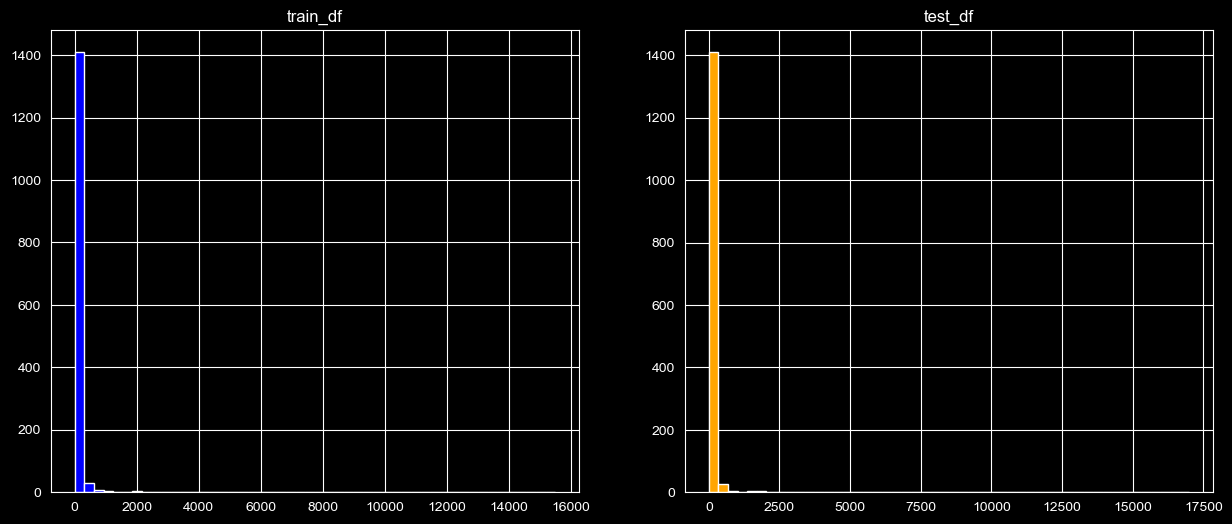

MoSold
                train_df      test_df
count        1460.000000  1459.000000
mean            6.321918     6.104181
std             2.703626     2.722432
min             1.000000     1.000000
25%             5.000000     4.000000
50%             6.000000     6.000000
75%             8.000000     8.000000
max            12.000000    12.000000
per missing     0.000000     0.000000


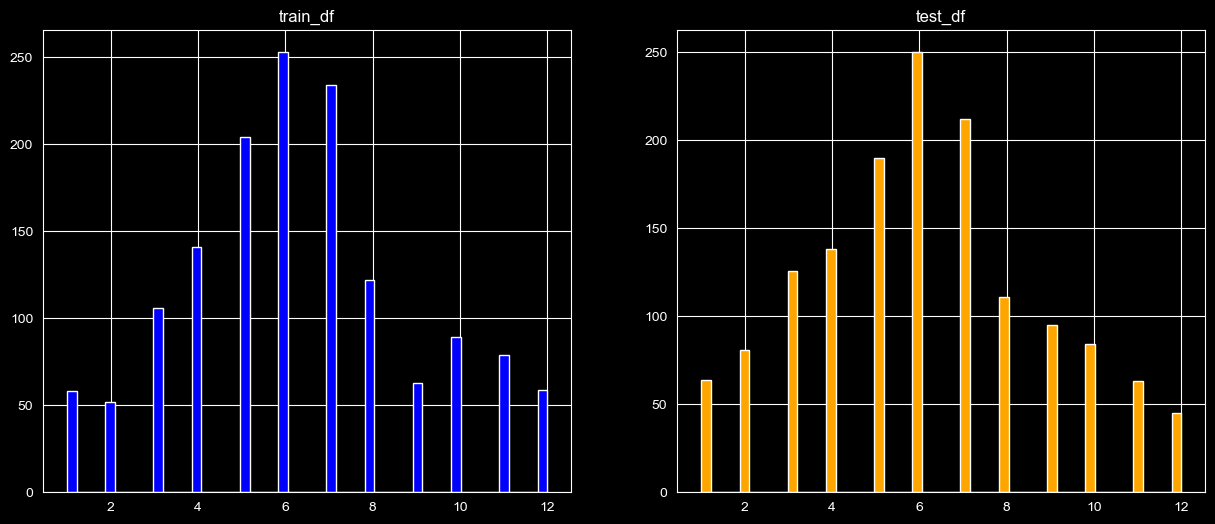

YrSold
                train_df      test_df
count        1460.000000  1459.000000
mean         2007.815753  2007.769705
std             1.328095     1.301740
min          2006.000000  2006.000000
25%          2007.000000  2007.000000
50%          2008.000000  2008.000000
75%          2009.000000  2009.000000
max          2010.000000  2010.000000
per missing     0.000000     0.000000


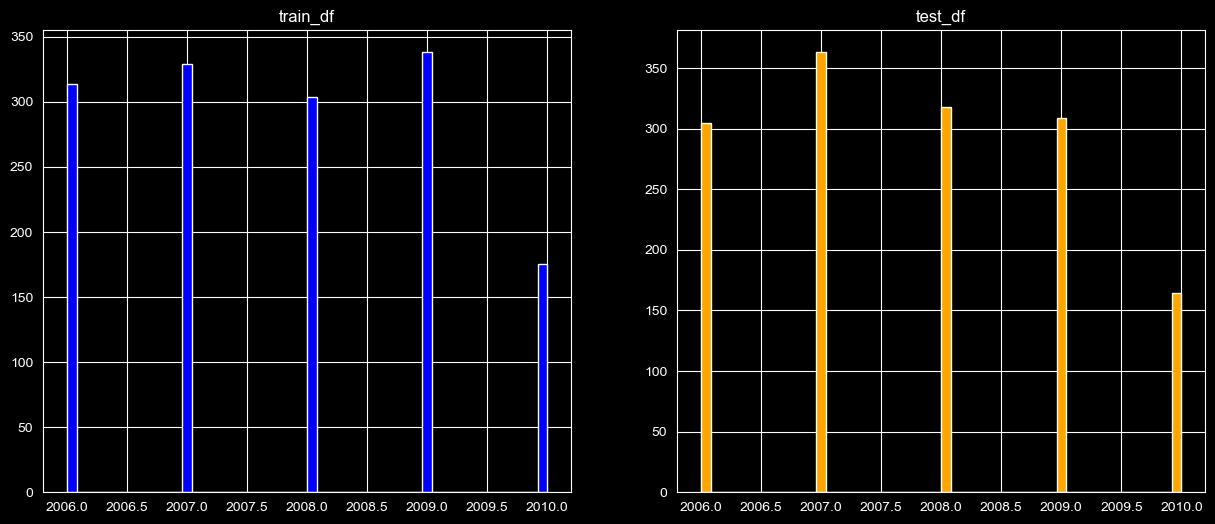

In [42]:
for num_col in num_cols:
    print(num_col)
    print(describe_col(num_col))
    plot_multi_hist(train_df, test_df, num_col, 'train_df', 'test_df', bins=50)

[0]	validation_0-rmse:0.32564
[1]	validation_0-rmse:0.26371
[2]	validation_0-rmse:0.22890
[3]	validation_0-rmse:0.20064
[4]	validation_0-rmse:0.18414
[5]	validation_0-rmse:0.17209
[6]	validation_0-rmse:0.16371
[7]	validation_0-rmse:0.15872
[8]	validation_0-rmse:0.15701
[9]	validation_0-rmse:0.15402
[10]	validation_0-rmse:0.15336
[11]	validation_0-rmse:0.15251
[12]	validation_0-rmse:0.15117
[13]	validation_0-rmse:0.15094
[14]	validation_0-rmse:0.15030
[15]	validation_0-rmse:0.14984
[16]	validation_0-rmse:0.14995
[17]	validation_0-rmse:0.14878
[18]	validation_0-rmse:0.14874
[19]	validation_0-rmse:0.14882
[20]	validation_0-rmse:0.14898
[21]	validation_0-rmse:0.14890
[22]	validation_0-rmse:0.14861
[23]	validation_0-rmse:0.14864
[24]	validation_0-rmse:0.14845
[25]	validation_0-rmse:0.14864
[26]	validation_0-rmse:0.14860
[27]	validation_0-rmse:0.14847
[28]	validation_0-rmse:0.14817
[29]	validation_0-rmse:0.14815
[30]	validation_0-rmse:0.14814
[31]	validation_0-rmse:0.14846
[32]	validation_0-

/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [13:47:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "early_stopping" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[83]	validation_0-rmse:0.14918
[84]	validation_0-rmse:0.14917
[85]	validation_0-rmse:0.14916
[86]	validation_0-rmse:0.14918
[87]	validation_0-rmse:0.14920
[88]	validation_0-rmse:0.14924
[89]	validation_0-rmse:0.14924
[90]	validation_0-rmse:0.14922
[91]	validation_0-rmse:0.14921
[92]	validation_0-rmse:0.14921
[93]	validation_0-rmse:0.14920
[94]	validation_0-rmse:0.14924
[95]	validation_0-rmse:0.14926
[96]	validation_0-rmse:0.14920
[97]	validation_0-rmse:0.14920
[98]	validation_0-rmse:0.14921
[99]	validation_0-rmse:0.14923
Simple Model RMSE: 0.14192528471687765


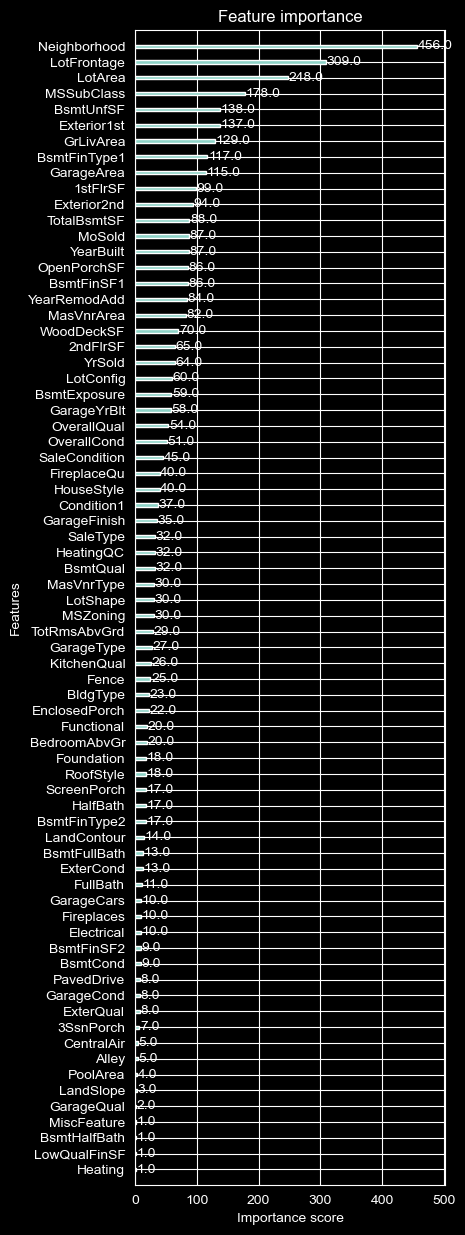

In [30]:
X[cat_cols] = X[cat_cols].astype('category')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

params = {
    "objective": "reg:squarederror",
    "seed": RANDOM_STATE,
    'enable_categorical': True,
    'early_stopping': 20
}

# Instantiate XGBClassifier with the parameters
model = xgb.XGBRegressor(**params)
# Train the model with early stopping
model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

preds = model.predict(X_test)
simple_rmse = np.sqrt(mean_squared_error(y_test, preds))
print("Simple Model RMSE:", simple_rmse)

fig, ax = plt.subplots(figsize=(4, 15))
xgb.plot_importance(model, ax=ax)
plt.show()

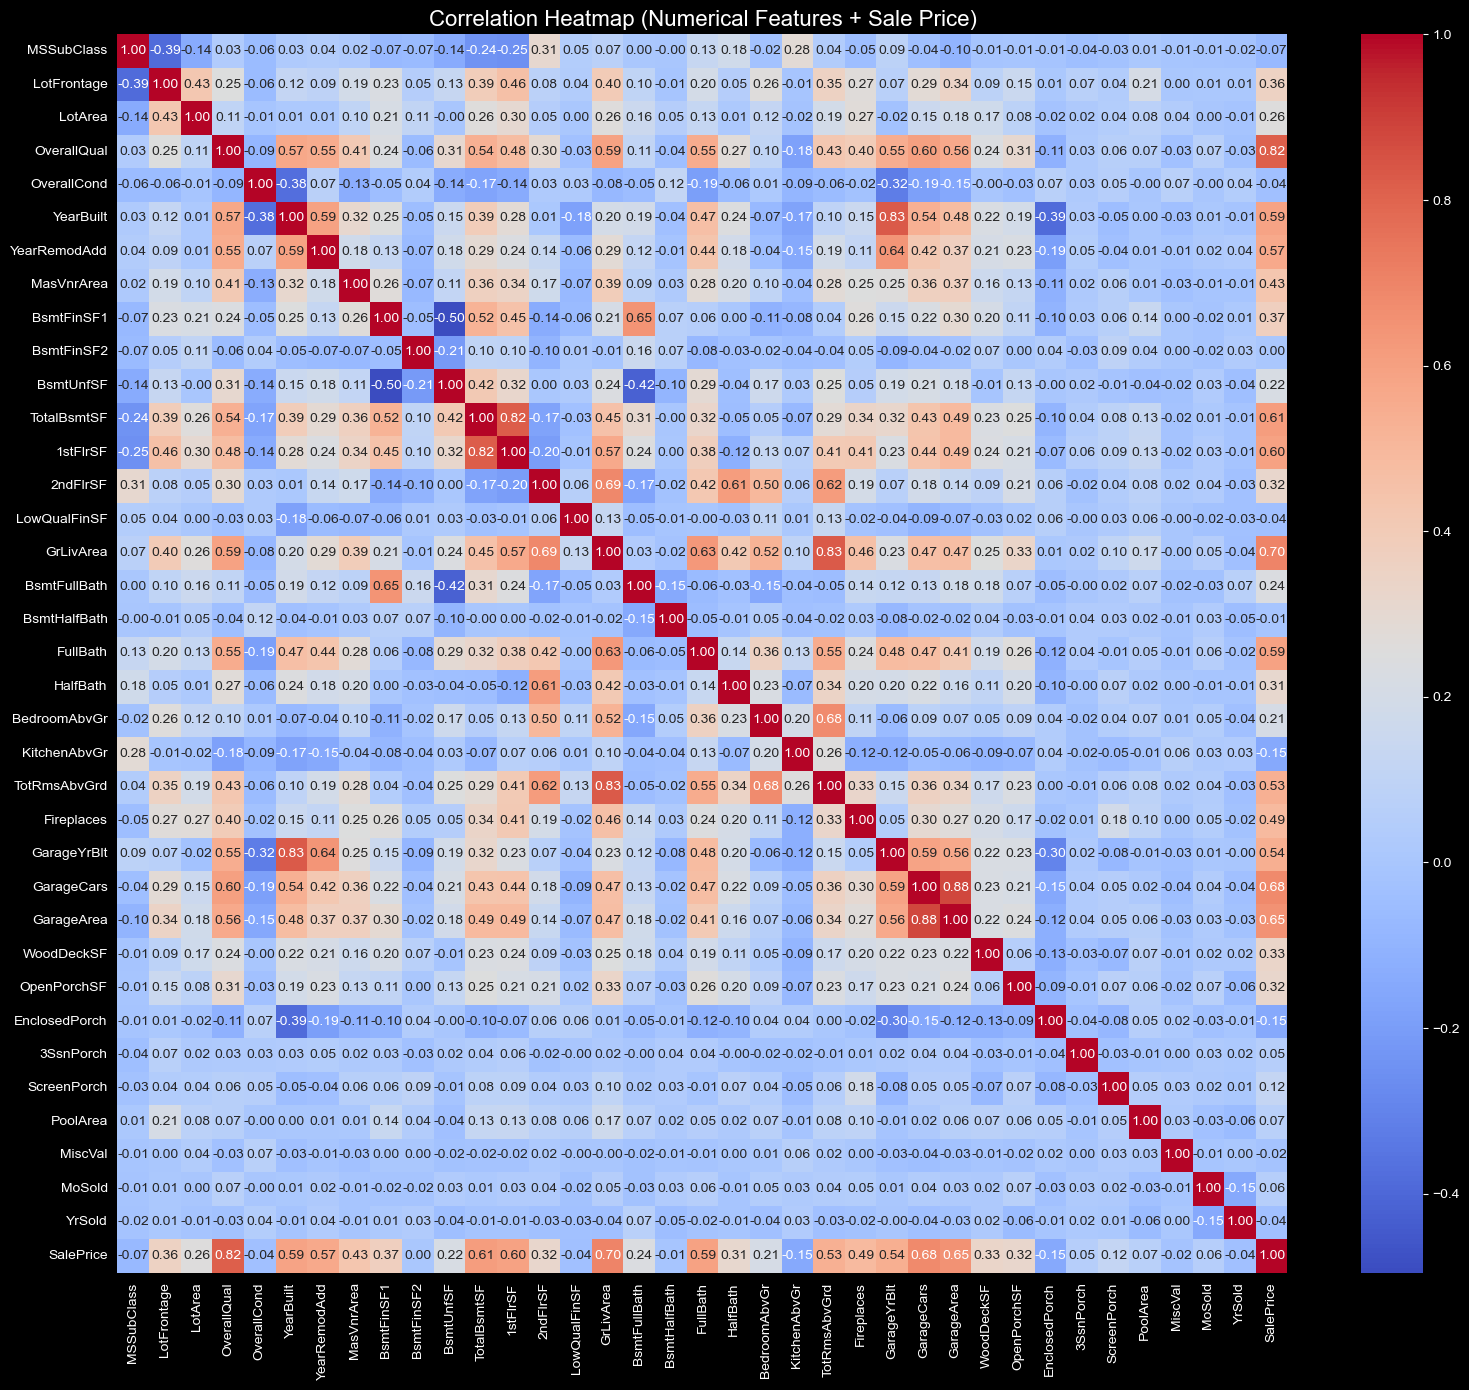

In [31]:
# Compute correlation matrix
corr_matrix = pd.concat([X[num_cols], y],axis=1).corr()


# Plot heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap (Numerical Features + Sale Price)', fontsize=16)
plt.tight_layout()
plt.show()

In [39]:
print(train_df[train_df['TotalBsmtSF'] != 0]['BsmtQual'].isnull().sum())
print(train_df[train_df['TotalBsmtSF'] != 0]['BsmtCond'].isnull().sum())
print(train_df[train_df['TotalBsmtSF'] != 0]['BsmtExposure'].isnull().sum())
print(train_df[train_df['TotalBsmtSF'] != 0]['BsmtFinType1'].isnull().sum())
print(train_df[train_df['BsmtFinSF2'] != 0]['BsmtFinType2'].isnull().sum())

0
0
1
0
1


In [62]:
print(train_df[num_cols].isnull().sum().sort_values(ascending=False) / len(train_df))
print(test_df[num_cols].isnull().sum().sort_values(ascending=False) / len(test_df))

LotFrontage      0.177397
GarageYrBlt      0.055479
MasVnrArea       0.005479
WoodDeckSF       0.000000
BedroomAbvGr     0.000000
KitchenAbvGr     0.000000
TotRmsAbvGrd     0.000000
Fireplaces       0.000000
GarageCars       0.000000
GarageArea       0.000000
MSSubClass       0.000000
HalfBath         0.000000
EnclosedPorch    0.000000
3SsnPorch        0.000000
ScreenPorch      0.000000
PoolArea         0.000000
MiscVal          0.000000
MoSold           0.000000
OpenPorchSF      0.000000
FullBath         0.000000
BsmtHalfBath     0.000000
BsmtFullBath     0.000000
GrLivArea        0.000000
LowQualFinSF     0.000000
2ndFlrSF         0.000000
1stFlrSF         0.000000
TotalBsmtSF      0.000000
BsmtUnfSF        0.000000
BsmtFinSF2       0.000000
BsmtFinSF1       0.000000
YearRemodAdd     0.000000
YearBuilt        0.000000
OverallCond      0.000000
OverallQual      0.000000
LotArea          0.000000
YrSold           0.000000
dtype: float64
LotFrontage      0.155586
GarageYrBlt      0.0534

In [47]:
train_df[train_df['MasVnrArea'].isnull()][['MasVnrType', 'MasVnrArea']]

,MasVnrType,MasVnrArea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


In [55]:
print(train_df['MasVnrType'].value_counts(dropna=False))

MasVnrType
NaN        872
BrkFace    445
Stone      128
BrkCmn      15
Name: count, dtype: int64


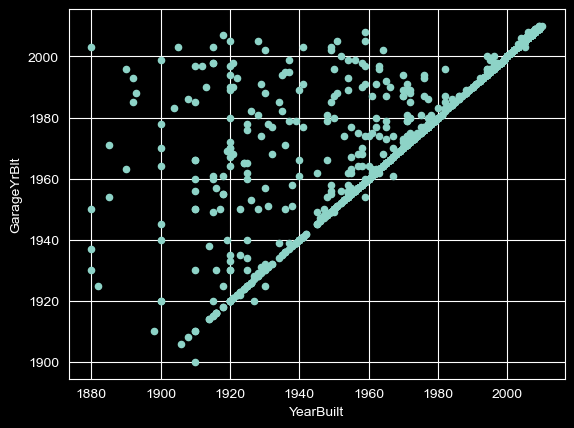

In [56]:
train_df.plot.scatter(x='YearBuilt', y='GarageYrBlt')
plt.show()

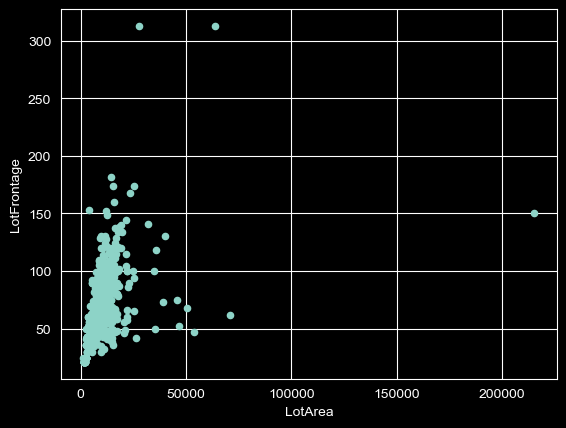

In [57]:
train_df.plot.scatter(x='LotArea', y='LotFrontage')
plt.show()

<Axes: xlabel='LotConfig', ylabel='LotFrontage'>

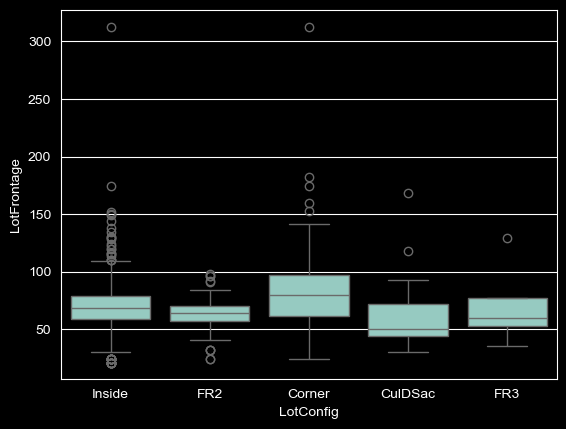

In [61]:
sns.boxplot(x='LotConfig', y='LotFrontage', data=train_df, orient='v')


<Axes: xlabel='LotShape', ylabel='LotFrontage'>

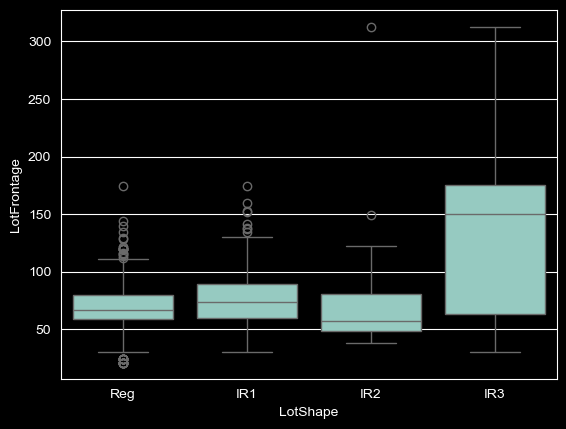

In [60]:
sns.boxplot(x='LotShape', y='LotFrontage', data=train_df, orient='v')